This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import ttest_ind

In [2]:
# set the path to the data
sum_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/sum_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
sum_aggregated_data_pca = pd.read_parquet(sum_aggregated_data_pca_path)
print(sum_aggregated_data_pca.shape)
sum_aggregated_data_pca.head()

(42, 44)


,Metadata_genotype,Metadata_replicate,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,High-Severity,1,-2.612687,2.480900,1.038433,-2.124206,1.848401,-0.138879,0.610879,-1.240955,...,1.737607,0.665385,-1.508575,-0.002393,-1.269638,0.005696,0.640564,0.873191,-0.304305,-9.020562e-16
1,High-Severity,10,1.744949,8.499953,2.922399,-1.102377,-0.962470,1.636088,1.463812,2.400998,...,-0.030647,0.118004,-1.435196,2.127940,-0.683266,-0.594841,-0.847429,-0.543167,0.226587,-6.106227e-16
2,High-Severity,11,1.118178,10.555786,1.918724,-1.821125,1.678552,-0.607047,-1.070299,-0.952239,...,0.164507,1.273944,0.585109,0.301258,-0.100187,0.409482,0.292690,-0.419133,0.090811,-1.665335e-16
3,High-Severity,12,-0.267551,7.238575,3.193898,-0.921462,-1.421467,3.201197,0.876403,1.133883,...,-0.788146,0.724145,-0.588942,0.030300,0.712927,0.415672,2.116853,-0.583968,0.414338,-6.661338e-16
4,High-Severity,13,-0.810176,6.274105,4.030843,0.668752,-0.999091,3.636388,0.282499,-2.773985,...,-1.040199,-1.076102,-0.000303,-0.058833,-0.736013,0.174054,-0.917179,1.114349,0.339969,3.400058e-16


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA components 1 and 2
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

14 14 14


In [4]:
# drop the the Metadata columns
high_severity = high_severity.drop(columns=["Metadata_genotype", "Metadata_replicate"])
low_severity = low_severity.drop(columns=["Metadata_genotype", "Metadata_replicate"])
wt = wt.drop(columns=["Metadata_genotype", "Metadata_replicate"])
# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(14, 42) (14, 42) (14, 42)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 7.874466036404469


/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 6.549257169182537


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 10.91040663213425


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                                    | 0/1000 [00:00<?, ?it/s]

  0%|                                                            | 1/1000 [00:00<02:57,  5.62it/s]

  0%|                                                            | 2/1000 [00:00<02:38,  6.29it/s]

  0%|▏                                                           | 3/1000 [00:00<02:32,  6.55it/s]

  0%|▏                                                           | 4/1000 [00:00<02:28,  6.69it/s]

  0%|▎                                                           | 5/1000 [00:00<02:27,  6.77it/s]

  1%|▎                                                           | 6/1000 [00:00<02:26,  6.81it/s]

  1%|▍                                                           | 7/1000 [00:01<02:25,  6.81it/s]

  1%|▍                                                           | 8/1000 [00:01<02:26,  6.76it/s]

  1%|▌                                                           | 9/1000 [00:01<02:25,  6.79it/s]

  1%|▌                                                          | 10/1000 [00:01<02:25,  6.82it/s]

  1%|▋                                                          | 11/1000 [00:01<02:24,  6.84it/s]

  1%|▋                                                          | 12/1000 [00:01<02:23,  6.88it/s]

  1%|▊                                                          | 13/1000 [00:01<02:23,  6.89it/s]

  1%|▊                                                          | 14/1000 [00:02<02:23,  6.85it/s]

  2%|▉                                                          | 15/1000 [00:02<02:23,  6.87it/s]

  2%|▉                                                          | 16/1000 [00:02<02:23,  6.88it/s]

  2%|█                                                          | 17/1000 [00:02<02:23,  6.86it/s]

  2%|█                                                          | 18/1000 [00:02<02:22,  6.88it/s]

  2%|█                                                          | 19/1000 [00:02<02:22,  6.89it/s]

  2%|█▏                                                         | 20/1000 [00:02<02:22,  6.90it/s]

  2%|█▏                                                         | 21/1000 [00:03<02:22,  6.89it/s]

  2%|█▎                                                         | 22/1000 [00:03<02:21,  6.90it/s]

  2%|█▎                                                         | 23/1000 [00:03<02:21,  6.90it/s]

  2%|█▍                                                         | 24/1000 [00:03<02:21,  6.91it/s]

  2%|█▍                                                         | 25/1000 [00:03<02:21,  6.91it/s]

  3%|█▌                                                         | 26/1000 [00:03<02:20,  6.92it/s]

  3%|█▌                                                         | 27/1000 [00:03<02:20,  6.93it/s]

  3%|█▋                                                         | 28/1000 [00:04<02:20,  6.92it/s]

  3%|█▋                                                         | 29/1000 [00:04<02:20,  6.91it/s]

  3%|█▊                                                         | 30/1000 [00:04<02:20,  6.91it/s]

  3%|█▊                                                         | 31/1000 [00:04<02:20,  6.91it/s]

  3%|█▉                                                         | 32/1000 [00:04<02:20,  6.88it/s]

  3%|█▉                                                         | 33/1000 [00:04<02:24,  6.69it/s]

  3%|██                                                         | 34/1000 [00:04<02:25,  6.65it/s]

  4%|██                                                         | 35/1000 [00:05<02:25,  6.64it/s]

  4%|██                                                         | 36/1000 [00:05<02:23,  6.71it/s]

  4%|██▏                                                        | 37/1000 [00:05<02:22,  6.78it/s]

  4%|██▏                                                        | 38/1000 [00:05<02:21,  6.81it/s]

  4%|██▎                                                        | 39/1000 [00:05<02:20,  6.84it/s]

  4%|██▎                                                        | 40/1000 [00:05<02:19,  6.87it/s]

  4%|██▍                                                        | 41/1000 [00:06<02:19,  6.87it/s]

  4%|██▍                                                        | 42/1000 [00:06<02:19,  6.88it/s]

  4%|██▌                                                        | 43/1000 [00:06<02:18,  6.90it/s]

  4%|██▌                                                        | 44/1000 [00:06<02:19,  6.83it/s]

  4%|██▋                                                        | 45/1000 [00:06<02:22,  6.71it/s]

  5%|██▋                                                        | 46/1000 [00:06<02:20,  6.77it/s]

  5%|██▊                                                        | 47/1000 [00:06<02:20,  6.78it/s]

  5%|██▊                                                        | 48/1000 [00:07<02:19,  6.82it/s]

  5%|██▉                                                        | 49/1000 [00:07<02:18,  6.86it/s]

  5%|██▉                                                        | 50/1000 [00:07<02:18,  6.87it/s]

  5%|███                                                        | 51/1000 [00:07<02:17,  6.89it/s]

  5%|███                                                        | 52/1000 [00:07<02:17,  6.91it/s]

  5%|███▏                                                       | 53/1000 [00:07<02:16,  6.91it/s]

  5%|███▏                                                       | 54/1000 [00:07<02:16,  6.92it/s]

  6%|███▏                                                       | 55/1000 [00:08<02:16,  6.92it/s]

  6%|███▎                                                       | 56/1000 [00:08<02:16,  6.92it/s]

  6%|███▎                                                       | 57/1000 [00:08<02:16,  6.92it/s]

  6%|███▍                                                       | 58/1000 [00:08<02:16,  6.92it/s]

  6%|███▍                                                       | 59/1000 [00:08<02:15,  6.92it/s]

  6%|███▌                                                       | 60/1000 [00:08<02:15,  6.93it/s]

  6%|███▌                                                       | 61/1000 [00:08<02:15,  6.92it/s]

  6%|███▋                                                       | 62/1000 [00:09<02:15,  6.94it/s]

  6%|███▋                                                       | 63/1000 [00:09<02:17,  6.79it/s]

  6%|███▊                                                       | 64/1000 [00:09<02:17,  6.81it/s]

  6%|███▊                                                       | 65/1000 [00:09<02:16,  6.85it/s]

  7%|███▉                                                       | 66/1000 [00:09<02:15,  6.88it/s]

  7%|███▉                                                       | 67/1000 [00:09<02:15,  6.90it/s]

  7%|████                                                       | 68/1000 [00:09<02:14,  6.91it/s]

  7%|████                                                       | 69/1000 [00:10<02:14,  6.91it/s]

  7%|████▏                                                      | 70/1000 [00:10<02:15,  6.86it/s]

  7%|████▏                                                      | 71/1000 [00:10<02:15,  6.87it/s]

  7%|████▏                                                      | 72/1000 [00:10<02:15,  6.86it/s]

  7%|████▎                                                      | 73/1000 [00:10<02:14,  6.87it/s]

  7%|████▎                                                      | 74/1000 [00:10<02:14,  6.89it/s]

  8%|████▍                                                      | 75/1000 [00:10<02:14,  6.90it/s]

  8%|████▍                                                      | 76/1000 [00:11<02:13,  6.91it/s]

  8%|████▌                                                      | 77/1000 [00:11<02:17,  6.72it/s]

  8%|████▌                                                      | 78/1000 [00:11<02:16,  6.78it/s]

  8%|████▋                                                      | 79/1000 [00:11<02:15,  6.81it/s]

  8%|████▋                                                      | 80/1000 [00:11<02:14,  6.84it/s]

  8%|████▊                                                      | 81/1000 [00:11<02:14,  6.86it/s]

  8%|████▊                                                      | 82/1000 [00:11<02:13,  6.88it/s]

  8%|████▉                                                      | 83/1000 [00:12<02:13,  6.88it/s]

  8%|████▉                                                      | 84/1000 [00:12<02:12,  6.90it/s]

  8%|█████                                                      | 85/1000 [00:12<02:12,  6.91it/s]

  9%|█████                                                      | 86/1000 [00:12<02:12,  6.91it/s]

  9%|█████▏                                                     | 87/1000 [00:12<02:12,  6.91it/s]

  9%|█████▏                                                     | 88/1000 [00:12<02:11,  6.92it/s]

  9%|█████▎                                                     | 89/1000 [00:12<02:11,  6.90it/s]

  9%|█████▎                                                     | 90/1000 [00:13<02:11,  6.92it/s]

  9%|█████▎                                                     | 91/1000 [00:13<02:12,  6.84it/s]

  9%|█████▍                                                     | 92/1000 [00:13<02:12,  6.83it/s]

  9%|█████▍                                                     | 93/1000 [00:13<02:12,  6.85it/s]

  9%|█████▌                                                     | 94/1000 [00:13<02:12,  6.86it/s]

 10%|█████▌                                                     | 95/1000 [00:13<02:22,  6.34it/s]

 10%|█████▋                                                     | 96/1000 [00:14<02:20,  6.44it/s]

 10%|█████▋                                                     | 97/1000 [00:14<02:17,  6.56it/s]

 10%|█████▊                                                     | 98/1000 [00:14<02:15,  6.65it/s]

 10%|█████▊                                                     | 99/1000 [00:14<02:14,  6.69it/s]

 10%|█████▊                                                    | 100/1000 [00:14<02:13,  6.75it/s]

 10%|█████▊                                                    | 101/1000 [00:14<02:12,  6.80it/s]

 10%|█████▉                                                    | 102/1000 [00:14<02:11,  6.83it/s]

 10%|█████▉                                                    | 103/1000 [00:15<02:10,  6.85it/s]

 10%|██████                                                    | 104/1000 [00:15<02:10,  6.87it/s]

 10%|██████                                                    | 105/1000 [00:15<02:09,  6.89it/s]

 11%|██████▏                                                   | 106/1000 [00:15<02:09,  6.89it/s]

 11%|██████▏                                                   | 107/1000 [00:15<02:09,  6.90it/s]

 11%|██████▎                                                   | 108/1000 [00:15<02:09,  6.90it/s]

 11%|██████▎                                                   | 109/1000 [00:15<02:11,  6.80it/s]

 11%|██████▍                                                   | 110/1000 [00:16<02:10,  6.83it/s]

 11%|██████▍                                                   | 111/1000 [00:16<02:10,  6.82it/s]

 11%|██████▍                                                   | 112/1000 [00:16<02:09,  6.85it/s]

 11%|██████▌                                                   | 113/1000 [00:16<02:08,  6.88it/s]

 11%|██████▌                                                   | 114/1000 [00:16<02:08,  6.89it/s]

 12%|██████▋                                                   | 115/1000 [00:16<02:07,  6.92it/s]

 12%|██████▋                                                   | 116/1000 [00:16<02:07,  6.96it/s]

 12%|██████▊                                                   | 117/1000 [00:17<02:06,  6.96it/s]

 12%|██████▊                                                   | 118/1000 [00:17<02:07,  6.94it/s]

 12%|██████▉                                                   | 119/1000 [00:17<02:06,  6.94it/s]

 12%|██████▉                                                   | 120/1000 [00:17<02:07,  6.93it/s]

 12%|███████                                                   | 121/1000 [00:17<02:06,  6.92it/s]

 12%|███████                                                   | 122/1000 [00:17<02:07,  6.90it/s]

 12%|███████▏                                                  | 123/1000 [00:17<02:07,  6.90it/s]

 12%|███████▏                                                  | 124/1000 [00:18<02:06,  6.91it/s]

 12%|███████▎                                                  | 125/1000 [00:18<02:06,  6.91it/s]

 13%|███████▎                                                  | 126/1000 [00:18<02:06,  6.91it/s]

 13%|███████▎                                                  | 127/1000 [00:18<02:06,  6.88it/s]

 13%|███████▍                                                  | 128/1000 [00:18<02:06,  6.89it/s]

 13%|███████▍                                                  | 129/1000 [00:18<02:06,  6.89it/s]

 13%|███████▌                                                  | 130/1000 [00:18<02:06,  6.87it/s]

 13%|███████▌                                                  | 131/1000 [00:19<02:06,  6.88it/s]

 13%|███████▋                                                  | 132/1000 [00:19<02:06,  6.89it/s]

 13%|███████▋                                                  | 133/1000 [00:19<02:05,  6.89it/s]

 13%|███████▊                                                  | 134/1000 [00:19<02:05,  6.88it/s]

 14%|███████▊                                                  | 135/1000 [00:19<02:05,  6.88it/s]

 14%|███████▉                                                  | 136/1000 [00:19<02:05,  6.88it/s]

 14%|███████▉                                                  | 137/1000 [00:20<02:05,  6.89it/s]

 14%|████████                                                  | 138/1000 [00:20<02:05,  6.89it/s]

 14%|████████                                                  | 139/1000 [00:20<02:04,  6.90it/s]

 14%|████████                                                  | 140/1000 [00:20<02:04,  6.90it/s]

 14%|████████▏                                                 | 141/1000 [00:20<02:04,  6.90it/s]

 14%|████████▏                                                 | 142/1000 [00:20<02:04,  6.90it/s]

 14%|████████▎                                                 | 143/1000 [00:20<02:04,  6.90it/s]

 14%|████████▎                                                 | 144/1000 [00:21<02:04,  6.90it/s]

 14%|████████▍                                                 | 145/1000 [00:21<02:03,  6.90it/s]

 15%|████████▍                                                 | 146/1000 [00:21<02:05,  6.82it/s]

 15%|████████▌                                                 | 147/1000 [00:21<02:05,  6.80it/s]

 15%|████████▌                                                 | 148/1000 [00:21<02:04,  6.83it/s]

 15%|████████▋                                                 | 149/1000 [00:21<02:04,  6.84it/s]

 15%|████████▋                                                 | 150/1000 [00:21<02:03,  6.86it/s]

 15%|████████▊                                                 | 151/1000 [00:22<02:03,  6.86it/s]

 15%|████████▊                                                 | 152/1000 [00:22<02:03,  6.87it/s]

 15%|████████▊                                                 | 153/1000 [00:22<02:03,  6.88it/s]

 15%|████████▉                                                 | 154/1000 [00:22<02:03,  6.85it/s]

 16%|████████▉                                                 | 155/1000 [00:22<02:03,  6.87it/s]

 16%|█████████                                                 | 156/1000 [00:22<02:02,  6.88it/s]

 16%|█████████                                                 | 157/1000 [00:22<02:03,  6.84it/s]

 16%|█████████▏                                                | 158/1000 [00:23<02:02,  6.86it/s]

 16%|█████████▏                                                | 159/1000 [00:23<02:02,  6.88it/s]

 16%|█████████▎                                                | 160/1000 [00:23<02:01,  6.89it/s]

 16%|█████████▎                                                | 161/1000 [00:23<02:01,  6.90it/s]

 16%|█████████▍                                                | 162/1000 [00:23<02:01,  6.89it/s]

 16%|█████████▍                                                | 163/1000 [00:23<02:03,  6.76it/s]

 16%|█████████▌                                                | 164/1000 [00:23<02:04,  6.73it/s]

 16%|█████████▌                                                | 165/1000 [00:24<02:03,  6.73it/s]

 17%|█████████▋                                                | 166/1000 [00:24<02:04,  6.70it/s]

 17%|█████████▋                                                | 167/1000 [00:24<02:04,  6.71it/s]

 17%|█████████▋                                                | 168/1000 [00:24<02:04,  6.68it/s]

 17%|█████████▊                                                | 169/1000 [00:24<02:05,  6.63it/s]

 17%|█████████▊                                                | 170/1000 [00:24<02:06,  6.58it/s]

 17%|█████████▉                                                | 171/1000 [00:25<02:04,  6.66it/s]

 17%|█████████▉                                                | 172/1000 [00:25<02:03,  6.71it/s]

 17%|██████████                                                | 173/1000 [00:25<02:02,  6.76it/s]

 17%|██████████                                                | 174/1000 [00:25<02:01,  6.80it/s]

 18%|██████████▏                                               | 175/1000 [00:25<02:01,  6.78it/s]

 18%|██████████▏                                               | 176/1000 [00:25<02:00,  6.82it/s]

 18%|██████████▎                                               | 177/1000 [00:25<02:00,  6.83it/s]

 18%|██████████▎                                               | 178/1000 [00:26<01:59,  6.85it/s]

 18%|██████████▍                                               | 179/1000 [00:26<01:59,  6.87it/s]

 18%|██████████▍                                               | 180/1000 [00:26<01:59,  6.88it/s]

 18%|██████████▍                                               | 181/1000 [00:26<01:59,  6.86it/s]

 18%|██████████▌                                               | 182/1000 [00:26<01:59,  6.85it/s]

 18%|██████████▌                                               | 183/1000 [00:26<02:02,  6.69it/s]

 18%|██████████▋                                               | 184/1000 [00:26<02:03,  6.58it/s]

 18%|██████████▋                                               | 185/1000 [00:27<02:03,  6.58it/s]

 19%|██████████▊                                               | 186/1000 [00:27<02:02,  6.66it/s]

 19%|██████████▊                                               | 187/1000 [00:27<02:01,  6.72it/s]

 19%|██████████▉                                               | 188/1000 [00:27<01:59,  6.77it/s]

 19%|██████████▉                                               | 189/1000 [00:27<01:58,  6.82it/s]

 19%|███████████                                               | 190/1000 [00:27<01:58,  6.84it/s]

 19%|███████████                                               | 191/1000 [00:27<01:57,  6.86it/s]

 19%|███████████▏                                              | 192/1000 [00:28<01:57,  6.88it/s]

 19%|███████████▏                                              | 193/1000 [00:28<01:57,  6.87it/s]

 19%|███████████▎                                              | 194/1000 [00:28<01:57,  6.89it/s]

 20%|███████████▎                                              | 195/1000 [00:28<01:56,  6.89it/s]

 20%|███████████▎                                              | 196/1000 [00:28<01:56,  6.89it/s]

 20%|███████████▍                                              | 197/1000 [00:28<01:56,  6.91it/s]

 20%|███████████▍                                              | 198/1000 [00:28<01:56,  6.89it/s]

 20%|███████████▌                                              | 199/1000 [00:29<01:56,  6.90it/s]

 20%|███████████▌                                              | 200/1000 [00:29<01:55,  6.90it/s]

 20%|███████████▋                                              | 201/1000 [00:29<01:56,  6.84it/s]

 20%|███████████▋                                              | 202/1000 [00:29<01:57,  6.79it/s]

 20%|███████████▊                                              | 203/1000 [00:29<01:56,  6.82it/s]

 20%|███████████▊                                              | 204/1000 [00:29<02:01,  6.54it/s]

 20%|███████████▉                                              | 205/1000 [00:30<01:59,  6.64it/s]

 21%|███████████▉                                              | 206/1000 [00:30<02:00,  6.61it/s]

 21%|████████████                                              | 207/1000 [00:30<01:58,  6.67it/s]

 21%|████████████                                              | 208/1000 [00:30<01:58,  6.71it/s]

 21%|████████████                                              | 209/1000 [00:30<01:58,  6.68it/s]

 21%|████████████▏                                             | 210/1000 [00:30<01:57,  6.70it/s]

 21%|████████████▏                                             | 211/1000 [00:30<01:58,  6.66it/s]

 21%|████████████▎                                             | 212/1000 [00:31<01:57,  6.73it/s]

 21%|████████████▎                                             | 213/1000 [00:31<01:57,  6.72it/s]

 21%|████████████▍                                             | 214/1000 [00:31<01:55,  6.80it/s]

 22%|████████████▍                                             | 215/1000 [00:31<01:54,  6.84it/s]

 22%|████████████▌                                             | 216/1000 [00:31<01:54,  6.87it/s]

 22%|████████████▌                                             | 217/1000 [00:31<01:53,  6.88it/s]

 22%|████████████▋                                             | 218/1000 [00:31<01:53,  6.89it/s]

 22%|████████████▋                                             | 219/1000 [00:32<01:53,  6.90it/s]

 22%|████████████▊                                             | 220/1000 [00:32<01:53,  6.87it/s]

 22%|████████████▊                                             | 221/1000 [00:32<01:53,  6.87it/s]

 22%|████████████▉                                             | 222/1000 [00:32<01:54,  6.78it/s]

 22%|████████████▉                                             | 223/1000 [00:32<01:56,  6.66it/s]

 22%|████████████▉                                             | 224/1000 [00:32<01:55,  6.70it/s]

 22%|█████████████                                             | 225/1000 [00:32<01:55,  6.74it/s]

 23%|█████████████                                             | 226/1000 [00:33<01:54,  6.77it/s]

 23%|█████████████▏                                            | 227/1000 [00:33<01:54,  6.77it/s]

 23%|█████████████▏                                            | 228/1000 [00:33<01:56,  6.65it/s]

 23%|█████████████▎                                            | 229/1000 [00:33<01:55,  6.70it/s]

 23%|█████████████▎                                            | 230/1000 [00:33<01:54,  6.74it/s]

 23%|█████████████▍                                            | 231/1000 [00:33<01:53,  6.76it/s]

 23%|█████████████▍                                            | 232/1000 [00:34<01:53,  6.77it/s]

 23%|█████████████▌                                            | 233/1000 [00:34<01:52,  6.79it/s]

 23%|█████████████▌                                            | 234/1000 [00:34<01:52,  6.80it/s]

 24%|█████████████▋                                            | 235/1000 [00:34<01:52,  6.83it/s]

 24%|█████████████▋                                            | 236/1000 [00:34<01:52,  6.80it/s]

 24%|█████████████▋                                            | 237/1000 [00:34<01:51,  6.82it/s]

 24%|█████████████▊                                            | 238/1000 [00:34<01:51,  6.84it/s]

 24%|█████████████▊                                            | 239/1000 [00:35<01:50,  6.87it/s]

 24%|█████████████▉                                            | 240/1000 [00:35<01:50,  6.88it/s]

 24%|█████████████▉                                            | 241/1000 [00:35<01:51,  6.82it/s]

 24%|██████████████                                            | 242/1000 [00:35<01:51,  6.81it/s]

 24%|██████████████                                            | 243/1000 [00:35<01:50,  6.83it/s]

 24%|██████████████▏                                           | 244/1000 [00:35<01:51,  6.81it/s]

 24%|██████████████▏                                           | 245/1000 [00:35<01:53,  6.64it/s]

 25%|██████████████▎                                           | 246/1000 [00:36<01:52,  6.71it/s]

 25%|██████████████▎                                           | 247/1000 [00:36<01:51,  6.76it/s]

 25%|██████████████▍                                           | 248/1000 [00:36<01:50,  6.80it/s]

 25%|██████████████▍                                           | 249/1000 [00:36<01:50,  6.82it/s]

 25%|██████████████▌                                           | 250/1000 [00:36<01:49,  6.84it/s]

 25%|██████████████▌                                           | 251/1000 [00:36<01:49,  6.86it/s]

 25%|██████████████▌                                           | 252/1000 [00:36<01:48,  6.87it/s]

 25%|██████████████▋                                           | 253/1000 [00:37<01:48,  6.87it/s]

 25%|██████████████▋                                           | 254/1000 [00:37<01:48,  6.88it/s]

 26%|██████████████▊                                           | 255/1000 [00:37<01:48,  6.86it/s]

 26%|██████████████▊                                           | 256/1000 [00:37<01:48,  6.87it/s]

 26%|██████████████▉                                           | 257/1000 [00:37<01:48,  6.88it/s]

 26%|██████████████▉                                           | 258/1000 [00:37<01:48,  6.86it/s]

 26%|███████████████                                           | 259/1000 [00:37<01:47,  6.87it/s]

 26%|███████████████                                           | 260/1000 [00:38<01:47,  6.86it/s]

 26%|███████████████▏                                          | 261/1000 [00:38<01:47,  6.88it/s]

 26%|███████████████▏                                          | 262/1000 [00:38<01:47,  6.89it/s]

 26%|███████████████▎                                          | 263/1000 [00:38<01:47,  6.85it/s]

 26%|███████████████▎                                          | 264/1000 [00:38<01:47,  6.86it/s]

 26%|███████████████▎                                          | 265/1000 [00:38<01:46,  6.88it/s]

 27%|███████████████▍                                          | 266/1000 [00:38<01:46,  6.88it/s]

 27%|███████████████▍                                          | 267/1000 [00:39<01:46,  6.88it/s]

 27%|███████████████▌                                          | 268/1000 [00:39<01:46,  6.88it/s]

 27%|███████████████▌                                          | 269/1000 [00:39<01:46,  6.89it/s]

 27%|███████████████▋                                          | 270/1000 [00:39<01:45,  6.89it/s]

 27%|███████████████▋                                          | 271/1000 [00:39<01:45,  6.89it/s]

 27%|███████████████▊                                          | 272/1000 [00:39<01:45,  6.89it/s]

 27%|███████████████▊                                          | 273/1000 [00:39<01:45,  6.90it/s]

 27%|███████████████▉                                          | 274/1000 [00:40<01:45,  6.90it/s]

 28%|███████████████▉                                          | 275/1000 [00:40<01:45,  6.90it/s]

 28%|████████████████                                          | 276/1000 [00:40<01:44,  6.90it/s]

 28%|████████████████                                          | 277/1000 [00:40<01:44,  6.92it/s]

 28%|████████████████                                          | 278/1000 [00:40<01:44,  6.90it/s]

 28%|████████████████▏                                         | 279/1000 [00:40<01:47,  6.70it/s]

 28%|████████████████▏                                         | 280/1000 [00:41<01:46,  6.73it/s]

 28%|████████████████▎                                         | 281/1000 [00:41<01:45,  6.79it/s]

 28%|████████████████▎                                         | 282/1000 [00:41<01:46,  6.76it/s]

 28%|████████████████▍                                         | 283/1000 [00:41<01:51,  6.41it/s]

 28%|████████████████▍                                         | 284/1000 [00:41<01:49,  6.52it/s]

 28%|████████████████▌                                         | 285/1000 [00:41<01:47,  6.63it/s]

 29%|████████████████▌                                         | 286/1000 [00:41<01:46,  6.71it/s]

 29%|████████████████▋                                         | 287/1000 [00:42<01:45,  6.75it/s]

 29%|████████████████▋                                         | 288/1000 [00:42<01:44,  6.80it/s]

 29%|████████████████▊                                         | 289/1000 [00:42<01:44,  6.83it/s]

 29%|████████████████▊                                         | 290/1000 [00:42<01:44,  6.81it/s]

 29%|████████████████▉                                         | 291/1000 [00:42<01:43,  6.83it/s]

 29%|████████████████▉                                         | 292/1000 [00:42<01:43,  6.84it/s]

 29%|████████████████▉                                         | 293/1000 [00:42<01:43,  6.80it/s]

 29%|█████████████████                                         | 294/1000 [00:43<01:43,  6.80it/s]

 30%|█████████████████                                         | 295/1000 [00:43<01:43,  6.79it/s]

 30%|█████████████████▏                                        | 296/1000 [00:43<01:43,  6.79it/s]

 30%|█████████████████▏                                        | 297/1000 [00:43<01:43,  6.80it/s]

 30%|█████████████████▎                                        | 298/1000 [00:43<01:42,  6.82it/s]

 30%|█████████████████▎                                        | 299/1000 [00:43<01:45,  6.67it/s]

 30%|█████████████████▍                                        | 300/1000 [00:43<01:44,  6.73it/s]

 30%|█████████████████▍                                        | 301/1000 [00:44<01:43,  6.75it/s]

 30%|█████████████████▌                                        | 302/1000 [00:44<01:42,  6.79it/s]

 30%|█████████████████▌                                        | 303/1000 [00:44<01:42,  6.82it/s]

 30%|█████████████████▋                                        | 304/1000 [00:44<01:41,  6.83it/s]

 30%|█████████████████▋                                        | 305/1000 [00:44<01:41,  6.85it/s]

 31%|█████████████████▋                                        | 306/1000 [00:44<01:41,  6.85it/s]

 31%|█████████████████▊                                        | 307/1000 [00:45<01:40,  6.87it/s]

 31%|█████████████████▊                                        | 308/1000 [00:45<01:40,  6.88it/s]

 31%|█████████████████▉                                        | 309/1000 [00:45<01:40,  6.87it/s]

 31%|█████████████████▉                                        | 310/1000 [00:45<01:40,  6.87it/s]

 31%|██████████████████                                        | 311/1000 [00:45<01:40,  6.88it/s]

 31%|██████████████████                                        | 312/1000 [00:45<01:39,  6.89it/s]

 31%|██████████████████▏                                       | 313/1000 [00:45<01:40,  6.86it/s]

 31%|██████████████████▏                                       | 314/1000 [00:46<01:39,  6.88it/s]

 32%|██████████████████▎                                       | 315/1000 [00:46<01:39,  6.89it/s]

 32%|██████████████████▎                                       | 316/1000 [00:46<01:39,  6.89it/s]

 32%|██████████████████▍                                       | 317/1000 [00:46<01:39,  6.89it/s]

 32%|██████████████████▍                                       | 318/1000 [00:46<01:39,  6.85it/s]

 32%|██████████████████▌                                       | 319/1000 [00:46<01:39,  6.87it/s]

 32%|██████████████████▌                                       | 320/1000 [00:46<01:38,  6.88it/s]

 32%|██████████████████▌                                       | 321/1000 [00:47<01:38,  6.87it/s]

 32%|██████████████████▋                                       | 322/1000 [00:47<01:38,  6.87it/s]

 32%|██████████████████▋                                       | 323/1000 [00:47<01:38,  6.85it/s]

 32%|██████████████████▊                                       | 324/1000 [00:47<01:38,  6.85it/s]

 32%|██████████████████▊                                       | 325/1000 [00:47<01:38,  6.84it/s]

 33%|██████████████████▉                                       | 326/1000 [00:47<01:38,  6.85it/s]

 33%|██████████████████▉                                       | 327/1000 [00:47<01:38,  6.83it/s]

 33%|███████████████████                                       | 328/1000 [00:48<01:38,  6.84it/s]

 33%|███████████████████                                       | 329/1000 [00:48<01:38,  6.84it/s]

 33%|███████████████████▏                                      | 330/1000 [00:48<01:37,  6.85it/s]

 33%|███████████████████▏                                      | 331/1000 [00:48<01:37,  6.86it/s]

 33%|███████████████████▎                                      | 332/1000 [00:48<01:37,  6.87it/s]

 33%|███████████████████▎                                      | 333/1000 [00:48<01:37,  6.86it/s]

 33%|███████████████████▎                                      | 334/1000 [00:48<01:37,  6.86it/s]

 34%|███████████████████▍                                      | 335/1000 [00:49<01:36,  6.87it/s]

 34%|███████████████████▍                                      | 336/1000 [00:49<01:36,  6.87it/s]

 34%|███████████████████▌                                      | 337/1000 [00:49<01:36,  6.87it/s]

 34%|███████████████████▌                                      | 338/1000 [00:49<01:36,  6.86it/s]

 34%|███████████████████▋                                      | 339/1000 [00:49<01:36,  6.87it/s]

 34%|███████████████████▋                                      | 340/1000 [00:49<01:35,  6.88it/s]

 34%|███████████████████▊                                      | 341/1000 [00:49<01:35,  6.88it/s]

 34%|███████████████████▊                                      | 342/1000 [00:50<01:35,  6.88it/s]

 34%|███████████████████▉                                      | 343/1000 [00:50<01:35,  6.87it/s]

 34%|███████████████████▉                                      | 344/1000 [00:50<01:35,  6.88it/s]

 34%|████████████████████                                      | 345/1000 [00:50<01:35,  6.84it/s]

 35%|████████████████████                                      | 346/1000 [00:50<01:35,  6.86it/s]

 35%|████████████████████▏                                     | 347/1000 [00:50<01:35,  6.86it/s]

 35%|████████████████████▏                                     | 348/1000 [00:50<01:34,  6.87it/s]

 35%|████████████████████▏                                     | 349/1000 [00:51<01:34,  6.86it/s]

 35%|████████████████████▎                                     | 350/1000 [00:51<01:34,  6.86it/s]

 35%|████████████████████▎                                     | 351/1000 [00:51<01:34,  6.85it/s]

 35%|████████████████████▍                                     | 352/1000 [00:51<01:34,  6.87it/s]

 35%|████████████████████▍                                     | 353/1000 [00:51<01:34,  6.87it/s]

 35%|████████████████████▌                                     | 354/1000 [00:51<01:33,  6.88it/s]

 36%|████████████████████▌                                     | 355/1000 [00:51<01:33,  6.89it/s]

 36%|████████████████████▋                                     | 356/1000 [00:52<01:33,  6.89it/s]

 36%|████████████████████▋                                     | 357/1000 [00:52<01:33,  6.88it/s]

 36%|████████████████████▊                                     | 358/1000 [00:52<01:33,  6.85it/s]

 36%|████████████████████▊                                     | 359/1000 [00:52<01:33,  6.86it/s]

 36%|████████████████████▉                                     | 360/1000 [00:52<01:33,  6.88it/s]

 36%|████████████████████▉                                     | 361/1000 [00:52<01:32,  6.88it/s]

 36%|████████████████████▉                                     | 362/1000 [00:53<01:32,  6.87it/s]

 36%|█████████████████████                                     | 363/1000 [00:53<01:32,  6.88it/s]

 36%|█████████████████████                                     | 364/1000 [00:53<01:32,  6.89it/s]

 36%|█████████████████████▏                                    | 365/1000 [00:53<01:32,  6.86it/s]

 37%|█████████████████████▏                                    | 366/1000 [00:53<01:32,  6.87it/s]

 37%|█████████████████████▎                                    | 367/1000 [00:53<01:32,  6.88it/s]

 37%|█████████████████████▎                                    | 368/1000 [00:53<01:31,  6.89it/s]

 37%|█████████████████████▍                                    | 369/1000 [00:54<01:31,  6.89it/s]

 37%|█████████████████████▍                                    | 370/1000 [00:54<01:31,  6.88it/s]

 37%|█████████████████████▌                                    | 371/1000 [00:54<01:31,  6.89it/s]

 37%|█████████████████████▌                                    | 372/1000 [00:54<01:31,  6.89it/s]

 37%|█████████████████████▋                                    | 373/1000 [00:54<01:31,  6.85it/s]

 37%|█████████████████████▋                                    | 374/1000 [00:54<01:33,  6.68it/s]

 38%|█████████████████████▊                                    | 375/1000 [00:54<01:33,  6.67it/s]

 38%|█████████████████████▊                                    | 376/1000 [00:55<01:32,  6.73it/s]

 38%|█████████████████████▊                                    | 377/1000 [00:55<01:32,  6.77it/s]

 38%|█████████████████████▉                                    | 378/1000 [00:55<01:31,  6.80it/s]

 38%|█████████████████████▉                                    | 379/1000 [00:55<01:30,  6.83it/s]

 38%|██████████████████████                                    | 380/1000 [00:55<01:30,  6.82it/s]

 38%|██████████████████████                                    | 381/1000 [00:55<01:30,  6.82it/s]

 38%|██████████████████████▏                                   | 382/1000 [00:55<01:32,  6.65it/s]

 38%|██████████████████████▏                                   | 383/1000 [00:56<01:31,  6.72it/s]

 38%|██████████████████████▎                                   | 384/1000 [00:56<01:30,  6.78it/s]

 38%|██████████████████████▎                                   | 385/1000 [00:56<01:30,  6.81it/s]

 39%|██████████████████████▍                                   | 386/1000 [00:56<01:29,  6.82it/s]

 39%|██████████████████████▍                                   | 387/1000 [00:56<01:29,  6.85it/s]

 39%|██████████████████████▌                                   | 388/1000 [00:56<01:29,  6.86it/s]

 39%|██████████████████████▌                                   | 389/1000 [00:56<01:29,  6.84it/s]

 39%|██████████████████████▌                                   | 390/1000 [00:57<01:28,  6.85it/s]

 39%|██████████████████████▋                                   | 391/1000 [00:57<01:28,  6.86it/s]

 39%|██████████████████████▋                                   | 392/1000 [00:57<01:28,  6.87it/s]

 39%|██████████████████████▊                                   | 393/1000 [00:57<01:28,  6.88it/s]

 39%|██████████████████████▊                                   | 394/1000 [00:57<01:28,  6.88it/s]

 40%|██████████████████████▉                                   | 395/1000 [00:57<01:33,  6.49it/s]

 40%|██████████████████████▉                                   | 396/1000 [00:58<01:36,  6.29it/s]

 40%|███████████████████████                                   | 397/1000 [00:58<01:33,  6.44it/s]

 40%|███████████████████████                                   | 398/1000 [00:58<01:31,  6.57it/s]

 40%|███████████████████████▏                                  | 399/1000 [00:58<01:30,  6.63it/s]

 40%|███████████████████████▏                                  | 400/1000 [00:58<01:29,  6.71it/s]

 40%|███████████████████████▎                                  | 401/1000 [00:58<01:28,  6.75it/s]

 40%|███████████████████████▎                                  | 402/1000 [00:58<01:28,  6.76it/s]

 40%|███████████████████████▎                                  | 403/1000 [00:59<01:27,  6.79it/s]

 40%|███████████████████████▍                                  | 404/1000 [00:59<01:27,  6.81it/s]

 40%|███████████████████████▍                                  | 405/1000 [00:59<01:27,  6.84it/s]

 41%|███████████████████████▌                                  | 406/1000 [00:59<01:26,  6.83it/s]

 41%|███████████████████████▌                                  | 407/1000 [00:59<01:26,  6.83it/s]

 41%|███████████████████████▋                                  | 408/1000 [00:59<01:26,  6.84it/s]

 41%|███████████████████████▋                                  | 409/1000 [00:59<01:26,  6.84it/s]

 41%|███████████████████████▊                                  | 410/1000 [01:00<01:26,  6.79it/s]

 41%|███████████████████████▊                                  | 411/1000 [01:00<01:28,  6.62it/s]

 41%|███████████████████████▉                                  | 412/1000 [01:00<01:27,  6.72it/s]

 41%|███████████████████████▉                                  | 413/1000 [01:00<01:26,  6.76it/s]

 41%|████████████████████████                                  | 414/1000 [01:00<01:26,  6.80it/s]

 42%|████████████████████████                                  | 415/1000 [01:00<01:25,  6.84it/s]

 42%|████████████████████████▏                                 | 416/1000 [01:00<01:25,  6.86it/s]

 42%|████████████████████████▏                                 | 417/1000 [01:01<01:24,  6.87it/s]

 42%|████████████████████████▏                                 | 418/1000 [01:01<01:24,  6.88it/s]

 42%|████████████████████████▎                                 | 419/1000 [01:01<01:24,  6.88it/s]

 42%|████████████████████████▎                                 | 420/1000 [01:01<01:24,  6.90it/s]

 42%|████████████████████████▍                                 | 421/1000 [01:01<01:23,  6.90it/s]

 42%|████████████████████████▍                                 | 422/1000 [01:01<01:23,  6.90it/s]

 42%|████████████████████████▌                                 | 423/1000 [01:01<01:23,  6.90it/s]

 42%|████████████████████████▌                                 | 424/1000 [01:02<01:23,  6.91it/s]

 42%|████████████████████████▋                                 | 425/1000 [01:02<01:23,  6.91it/s]

 43%|████████████████████████▋                                 | 426/1000 [01:02<01:23,  6.91it/s]

 43%|████████████████████████▊                                 | 427/1000 [01:02<01:23,  6.87it/s]

 43%|████████████████████████▊                                 | 428/1000 [01:02<01:23,  6.88it/s]

 43%|████████████████████████▉                                 | 429/1000 [01:02<01:22,  6.89it/s]

 43%|████████████████████████▉                                 | 430/1000 [01:03<01:22,  6.90it/s]

 43%|████████████████████████▉                                 | 431/1000 [01:03<01:22,  6.90it/s]

 43%|█████████████████████████                                 | 432/1000 [01:03<01:22,  6.91it/s]

 43%|█████████████████████████                                 | 433/1000 [01:03<01:22,  6.91it/s]

 43%|█████████████████████████▏                                | 434/1000 [01:03<01:21,  6.91it/s]

 44%|█████████████████████████▏                                | 435/1000 [01:03<01:21,  6.91it/s]

 44%|█████████████████████████▎                                | 436/1000 [01:03<01:21,  6.90it/s]

 44%|█████████████████████████▎                                | 437/1000 [01:04<01:21,  6.90it/s]

 44%|█████████████████████████▍                                | 438/1000 [01:04<01:21,  6.89it/s]

 44%|█████████████████████████▍                                | 439/1000 [01:04<01:21,  6.90it/s]

 44%|█████████████████████████▌                                | 440/1000 [01:04<01:21,  6.86it/s]

 44%|█████████████████████████▌                                | 441/1000 [01:04<01:22,  6.81it/s]

 44%|█████████████████████████▋                                | 442/1000 [01:04<01:21,  6.85it/s]

 44%|█████████████████████████▋                                | 443/1000 [01:04<01:21,  6.87it/s]

 44%|█████████████████████████▊                                | 444/1000 [01:05<01:21,  6.84it/s]

 44%|█████████████████████████▊                                | 445/1000 [01:05<01:21,  6.82it/s]

 45%|█████████████████████████▊                                | 446/1000 [01:05<01:25,  6.52it/s]

 45%|█████████████████████████▉                                | 447/1000 [01:05<01:23,  6.61it/s]

 45%|█████████████████████████▉                                | 448/1000 [01:05<01:22,  6.68it/s]

 45%|██████████████████████████                                | 449/1000 [01:05<01:21,  6.74it/s]

 45%|██████████████████████████                                | 450/1000 [01:05<01:20,  6.79it/s]

 45%|██████████████████████████▏                               | 451/1000 [01:06<01:20,  6.83it/s]

 45%|██████████████████████████▏                               | 452/1000 [01:06<01:20,  6.84it/s]

 45%|██████████████████████████▎                               | 453/1000 [01:06<01:19,  6.85it/s]

 45%|██████████████████████████▎                               | 454/1000 [01:06<01:20,  6.82it/s]

 46%|██████████████████████████▍                               | 455/1000 [01:06<01:19,  6.84it/s]

 46%|██████████████████████████▍                               | 456/1000 [01:06<01:19,  6.85it/s]

 46%|██████████████████████████▌                               | 457/1000 [01:06<01:19,  6.86it/s]

 46%|██████████████████████████▌                               | 458/1000 [01:07<01:18,  6.86it/s]

 46%|██████████████████████████▌                               | 459/1000 [01:07<01:18,  6.87it/s]

 46%|██████████████████████████▋                               | 460/1000 [01:07<01:18,  6.88it/s]

 46%|██████████████████████████▋                               | 461/1000 [01:07<01:18,  6.88it/s]

 46%|██████████████████████████▊                               | 462/1000 [01:07<01:18,  6.89it/s]

 46%|██████████████████████████▊                               | 463/1000 [01:07<01:18,  6.86it/s]

 46%|██████████████████████████▉                               | 464/1000 [01:07<01:18,  6.87it/s]

 46%|██████████████████████████▉                               | 465/1000 [01:08<01:18,  6.85it/s]

 47%|███████████████████████████                               | 466/1000 [01:08<01:18,  6.84it/s]

 47%|███████████████████████████                               | 467/1000 [01:08<01:18,  6.82it/s]

 47%|███████████████████████████▏                              | 468/1000 [01:08<01:17,  6.84it/s]

 47%|███████████████████████████▏                              | 469/1000 [01:08<01:17,  6.86it/s]

 47%|███████████████████████████▎                              | 470/1000 [01:08<01:17,  6.86it/s]

 47%|███████████████████████████▎                              | 471/1000 [01:09<01:17,  6.86it/s]

 47%|███████████████████████████▍                              | 472/1000 [01:09<01:16,  6.88it/s]

 47%|███████████████████████████▍                              | 473/1000 [01:09<01:16,  6.88it/s]

 47%|███████████████████████████▍                              | 474/1000 [01:09<01:16,  6.86it/s]

 48%|███████████████████████████▌                              | 475/1000 [01:09<01:17,  6.78it/s]

 48%|███████████████████████████▌                              | 476/1000 [01:09<01:18,  6.72it/s]

 48%|███████████████████████████▋                              | 477/1000 [01:09<01:17,  6.75it/s]

 48%|███████████████████████████▋                              | 478/1000 [01:10<01:16,  6.79it/s]

 48%|███████████████████████████▊                              | 479/1000 [01:10<01:16,  6.83it/s]

 48%|███████████████████████████▊                              | 480/1000 [01:10<01:15,  6.84it/s]

 48%|███████████████████████████▉                              | 481/1000 [01:10<01:15,  6.86it/s]

 48%|███████████████████████████▉                              | 482/1000 [01:10<01:16,  6.76it/s]

 48%|████████████████████████████                              | 483/1000 [01:10<01:16,  6.80it/s]

 48%|████████████████████████████                              | 484/1000 [01:10<01:15,  6.82it/s]

 48%|████████████████████████████▏                             | 485/1000 [01:11<01:15,  6.84it/s]

 49%|████████████████████████████▏                             | 486/1000 [01:11<01:14,  6.86it/s]

 49%|████████████████████████████▏                             | 487/1000 [01:11<01:14,  6.87it/s]

 49%|████████████████████████████▎                             | 488/1000 [01:11<01:14,  6.87it/s]

 49%|████████████████████████████▎                             | 489/1000 [01:11<01:14,  6.88it/s]

 49%|████████████████████████████▍                             | 490/1000 [01:11<01:14,  6.88it/s]

 49%|████████████████████████████▍                             | 491/1000 [01:11<01:14,  6.88it/s]

 49%|████████████████████████████▌                             | 492/1000 [01:12<01:13,  6.88it/s]

 49%|████████████████████████████▌                             | 493/1000 [01:12<01:13,  6.88it/s]

 49%|████████████████████████████▋                             | 494/1000 [01:12<01:13,  6.89it/s]

 50%|████████████████████████████▋                             | 495/1000 [01:12<01:13,  6.88it/s]

 50%|████████████████████████████▊                             | 496/1000 [01:12<01:13,  6.88it/s]

 50%|████████████████████████████▊                             | 497/1000 [01:12<01:13,  6.89it/s]

 50%|████████████████████████████▉                             | 498/1000 [01:12<01:12,  6.89it/s]

 50%|████████████████████████████▉                             | 499/1000 [01:13<01:12,  6.89it/s]

 50%|█████████████████████████████                             | 500/1000 [01:13<01:12,  6.89it/s]

 50%|█████████████████████████████                             | 501/1000 [01:13<01:12,  6.89it/s]

 50%|█████████████████████████████                             | 502/1000 [01:13<01:12,  6.88it/s]

 50%|█████████████████████████████▏                            | 503/1000 [01:13<01:12,  6.88it/s]

 50%|█████████████████████████████▏                            | 504/1000 [01:13<01:12,  6.88it/s]

 50%|█████████████████████████████▎                            | 505/1000 [01:13<01:11,  6.89it/s]

 51%|█████████████████████████████▎                            | 506/1000 [01:14<01:11,  6.88it/s]

 51%|█████████████████████████████▍                            | 507/1000 [01:14<01:12,  6.82it/s]

 51%|█████████████████████████████▍                            | 508/1000 [01:14<01:11,  6.84it/s]

 51%|█████████████████████████████▌                            | 509/1000 [01:14<01:12,  6.82it/s]

 51%|█████████████████████████████▌                            | 510/1000 [01:14<01:11,  6.84it/s]

 51%|█████████████████████████████▋                            | 511/1000 [01:14<01:11,  6.85it/s]

 51%|█████████████████████████████▋                            | 512/1000 [01:14<01:11,  6.85it/s]

 51%|█████████████████████████████▊                            | 513/1000 [01:15<01:10,  6.86it/s]

 51%|█████████████████████████████▊                            | 514/1000 [01:15<01:10,  6.87it/s]

 52%|█████████████████████████████▊                            | 515/1000 [01:15<01:10,  6.88it/s]

 52%|█████████████████████████████▉                            | 516/1000 [01:15<01:10,  6.88it/s]

 52%|█████████████████████████████▉                            | 517/1000 [01:15<01:10,  6.89it/s]

 52%|██████████████████████████████                            | 518/1000 [01:15<01:10,  6.89it/s]

 52%|██████████████████████████████                            | 519/1000 [01:16<01:09,  6.88it/s]

 52%|██████████████████████████████▏                           | 520/1000 [01:16<01:09,  6.89it/s]

 52%|██████████████████████████████▏                           | 521/1000 [01:16<01:09,  6.89it/s]

 52%|██████████████████████████████▎                           | 522/1000 [01:16<01:09,  6.89it/s]

 52%|██████████████████████████████▎                           | 523/1000 [01:16<01:09,  6.88it/s]

 52%|██████████████████████████████▍                           | 524/1000 [01:16<01:09,  6.88it/s]

 52%|██████████████████████████████▍                           | 525/1000 [01:16<01:09,  6.80it/s]

 53%|██████████████████████████████▌                           | 526/1000 [01:17<01:09,  6.82it/s]

 53%|██████████████████████████████▌                           | 527/1000 [01:17<01:09,  6.84it/s]

 53%|██████████████████████████████▌                           | 528/1000 [01:17<01:08,  6.86it/s]

 53%|██████████████████████████████▋                           | 529/1000 [01:17<01:08,  6.87it/s]

 53%|██████████████████████████████▋                           | 530/1000 [01:17<01:08,  6.87it/s]

 53%|██████████████████████████████▊                           | 531/1000 [01:17<01:08,  6.87it/s]

 53%|██████████████████████████████▊                           | 532/1000 [01:17<01:08,  6.88it/s]

 53%|██████████████████████████████▉                           | 533/1000 [01:18<01:07,  6.88it/s]

 53%|██████████████████████████████▉                           | 534/1000 [01:18<01:07,  6.89it/s]

 54%|███████████████████████████████                           | 535/1000 [01:18<01:07,  6.89it/s]

 54%|███████████████████████████████                           | 536/1000 [01:18<01:07,  6.88it/s]

 54%|███████████████████████████████▏                          | 537/1000 [01:18<01:08,  6.80it/s]

 54%|███████████████████████████████▏                          | 538/1000 [01:18<01:07,  6.82it/s]

 54%|███████████████████████████████▎                          | 539/1000 [01:18<01:07,  6.82it/s]

 54%|███████████████████████████████▎                          | 540/1000 [01:19<01:07,  6.84it/s]

 54%|███████████████████████████████▍                          | 541/1000 [01:19<01:06,  6.86it/s]

 54%|███████████████████████████████▍                          | 542/1000 [01:19<01:06,  6.87it/s]

 54%|███████████████████████████████▍                          | 543/1000 [01:19<01:06,  6.86it/s]

 54%|███████████████████████████████▌                          | 544/1000 [01:19<01:06,  6.86it/s]

 55%|███████████████████████████████▌                          | 545/1000 [01:19<01:06,  6.87it/s]

 55%|███████████████████████████████▋                          | 546/1000 [01:19<01:06,  6.87it/s]

 55%|███████████████████████████████▋                          | 547/1000 [01:20<01:06,  6.86it/s]

 55%|███████████████████████████████▊                          | 548/1000 [01:20<01:05,  6.87it/s]

 55%|███████████████████████████████▊                          | 549/1000 [01:20<01:05,  6.88it/s]

 55%|███████████████████████████████▉                          | 550/1000 [01:20<01:05,  6.88it/s]

 55%|███████████████████████████████▉                          | 551/1000 [01:20<01:05,  6.88it/s]

 55%|████████████████████████████████                          | 552/1000 [01:20<01:05,  6.89it/s]

 55%|████████████████████████████████                          | 553/1000 [01:20<01:10,  6.35it/s]

 55%|████████████████████████████████▏                         | 554/1000 [01:21<01:08,  6.49it/s]

 56%|████████████████████████████████▏                         | 555/1000 [01:21<01:07,  6.59it/s]

 56%|████████████████████████████████▏                         | 556/1000 [01:21<01:06,  6.66it/s]

 56%|████████████████████████████████▎                         | 557/1000 [01:21<01:06,  6.71it/s]

 56%|████████████████████████████████▎                         | 558/1000 [01:21<01:05,  6.74it/s]

 56%|████████████████████████████████▍                         | 559/1000 [01:21<01:06,  6.63it/s]

 56%|████████████████████████████████▍                         | 560/1000 [01:22<01:05,  6.69it/s]

 56%|████████████████████████████████▌                         | 561/1000 [01:22<01:05,  6.71it/s]

 56%|████████████████████████████████▌                         | 562/1000 [01:22<01:04,  6.76it/s]

 56%|████████████████████████████████▋                         | 563/1000 [01:22<01:04,  6.78it/s]

 56%|████████████████████████████████▋                         | 564/1000 [01:22<01:04,  6.79it/s]

 56%|████████████████████████████████▊                         | 565/1000 [01:22<01:03,  6.82it/s]

 57%|████████████████████████████████▊                         | 566/1000 [01:22<01:04,  6.78it/s]

 57%|████████████████████████████████▉                         | 567/1000 [01:23<01:09,  6.21it/s]

 57%|████████████████████████████████▉                         | 568/1000 [01:23<01:07,  6.42it/s]

 57%|█████████████████████████████████                         | 569/1000 [01:23<01:06,  6.45it/s]

 57%|█████████████████████████████████                         | 570/1000 [01:23<01:06,  6.47it/s]

 57%|█████████████████████████████████                         | 571/1000 [01:23<01:05,  6.57it/s]

 57%|█████████████████████████████████▏                        | 572/1000 [01:23<01:04,  6.62it/s]

 57%|█████████████████████████████████▏                        | 573/1000 [01:23<01:03,  6.67it/s]

 57%|█████████████████████████████████▎                        | 574/1000 [01:24<01:04,  6.63it/s]

 57%|█████████████████████████████████▎                        | 575/1000 [01:24<01:03,  6.68it/s]

 58%|█████████████████████████████████▍                        | 576/1000 [01:24<01:03,  6.69it/s]

 58%|█████████████████████████████████▍                        | 577/1000 [01:24<01:03,  6.71it/s]

 58%|█████████████████████████████████▌                        | 578/1000 [01:24<01:02,  6.75it/s]

 58%|█████████████████████████████████▌                        | 579/1000 [01:24<01:02,  6.77it/s]

 58%|█████████████████████████████████▋                        | 580/1000 [01:25<01:01,  6.79it/s]

 58%|█████████████████████████████████▋                        | 581/1000 [01:25<01:01,  6.82it/s]

 58%|█████████████████████████████████▊                        | 582/1000 [01:25<01:01,  6.81it/s]

 58%|█████████████████████████████████▊                        | 583/1000 [01:25<01:01,  6.81it/s]

 58%|█████████████████████████████████▊                        | 584/1000 [01:25<01:00,  6.85it/s]

 58%|█████████████████████████████████▉                        | 585/1000 [01:25<01:01,  6.79it/s]

 59%|█████████████████████████████████▉                        | 586/1000 [01:25<01:05,  6.28it/s]

 59%|██████████████████████████████████                        | 587/1000 [01:26<01:03,  6.45it/s]

 59%|██████████████████████████████████                        | 588/1000 [01:26<01:02,  6.59it/s]

 59%|██████████████████████████████████▏                       | 589/1000 [01:26<01:01,  6.68it/s]

 59%|██████████████████████████████████▏                       | 590/1000 [01:26<01:00,  6.76it/s]

 59%|██████████████████████████████████▎                       | 591/1000 [01:26<01:00,  6.81it/s]

 59%|██████████████████████████████████▎                       | 592/1000 [01:26<00:59,  6.84it/s]

 59%|██████████████████████████████████▍                       | 593/1000 [01:26<00:59,  6.87it/s]

 59%|██████████████████████████████████▍                       | 594/1000 [01:27<01:00,  6.76it/s]

 60%|██████████████████████████████████▌                       | 595/1000 [01:27<00:59,  6.81it/s]

 60%|██████████████████████████████████▌                       | 596/1000 [01:27<00:58,  6.85it/s]

 60%|██████████████████████████████████▋                       | 597/1000 [01:27<00:58,  6.88it/s]

 60%|██████████████████████████████████▋                       | 598/1000 [01:27<00:58,  6.90it/s]

 60%|██████████████████████████████████▋                       | 599/1000 [01:27<00:58,  6.90it/s]

 60%|██████████████████████████████████▊                       | 600/1000 [01:27<00:57,  6.90it/s]

 60%|██████████████████████████████████▊                       | 601/1000 [01:28<00:57,  6.88it/s]

 60%|██████████████████████████████████▉                       | 602/1000 [01:28<00:58,  6.81it/s]

 60%|██████████████████████████████████▉                       | 603/1000 [01:28<00:58,  6.84it/s]

 60%|███████████████████████████████████                       | 604/1000 [01:28<00:58,  6.74it/s]

 60%|███████████████████████████████████                       | 605/1000 [01:28<00:58,  6.74it/s]

 61%|███████████████████████████████████▏                      | 606/1000 [01:28<00:58,  6.78it/s]

 61%|███████████████████████████████████▏                      | 607/1000 [01:29<00:57,  6.81it/s]

 61%|███████████████████████████████████▎                      | 608/1000 [01:29<00:57,  6.84it/s]

 61%|███████████████████████████████████▎                      | 609/1000 [01:29<00:56,  6.86it/s]

 61%|███████████████████████████████████▍                      | 610/1000 [01:29<00:56,  6.88it/s]

 61%|███████████████████████████████████▍                      | 611/1000 [01:29<00:56,  6.88it/s]

 61%|███████████████████████████████████▍                      | 612/1000 [01:29<00:56,  6.91it/s]

 61%|███████████████████████████████████▌                      | 613/1000 [01:29<00:55,  6.91it/s]

 61%|███████████████████████████████████▌                      | 614/1000 [01:30<00:56,  6.89it/s]

 62%|███████████████████████████████████▋                      | 615/1000 [01:30<00:55,  6.90it/s]

 62%|███████████████████████████████████▋                      | 616/1000 [01:30<00:57,  6.68it/s]

 62%|███████████████████████████████████▊                      | 617/1000 [01:30<00:56,  6.76it/s]

 62%|███████████████████████████████████▊                      | 618/1000 [01:30<00:56,  6.80it/s]

 62%|███████████████████████████████████▉                      | 619/1000 [01:30<00:56,  6.77it/s]

 62%|███████████████████████████████████▉                      | 620/1000 [01:30<00:56,  6.73it/s]

 62%|████████████████████████████████████                      | 621/1000 [01:31<00:55,  6.77it/s]

 62%|████████████████████████████████████                      | 622/1000 [01:31<00:56,  6.65it/s]

 62%|████████████████████████████████████▏                     | 623/1000 [01:31<00:57,  6.53it/s]

 62%|████████████████████████████████████▏                     | 624/1000 [01:31<00:56,  6.63it/s]

 62%|████████████████████████████████████▎                     | 625/1000 [01:31<00:56,  6.68it/s]

 63%|████████████████████████████████████▎                     | 626/1000 [01:31<00:55,  6.72it/s]

 63%|████████████████████████████████████▎                     | 627/1000 [01:31<00:55,  6.70it/s]

 63%|████████████████████████████████████▍                     | 628/1000 [01:32<00:55,  6.74it/s]

 63%|████████████████████████████████████▍                     | 629/1000 [01:32<00:56,  6.61it/s]

 63%|████████████████████████████████████▌                     | 630/1000 [01:32<00:55,  6.68it/s]

 63%|████████████████████████████████████▌                     | 631/1000 [01:32<00:54,  6.72it/s]

 63%|████████████████████████████████████▋                     | 632/1000 [01:32<00:54,  6.77it/s]

 63%|████████████████████████████████████▋                     | 633/1000 [01:32<00:53,  6.80it/s]

 63%|████████████████████████████████████▊                     | 634/1000 [01:33<00:53,  6.83it/s]

 64%|████████████████████████████████████▊                     | 635/1000 [01:33<00:54,  6.65it/s]

 64%|████████████████████████████████████▉                     | 636/1000 [01:33<00:54,  6.71it/s]

 64%|████████████████████████████████████▉                     | 637/1000 [01:33<00:53,  6.76it/s]

 64%|█████████████████████████████████████                     | 638/1000 [01:33<00:53,  6.80it/s]

 64%|█████████████████████████████████████                     | 639/1000 [01:33<00:52,  6.83it/s]

 64%|█████████████████████████████████████                     | 640/1000 [01:33<00:52,  6.86it/s]

 64%|█████████████████████████████████████▏                    | 641/1000 [01:34<00:52,  6.87it/s]

 64%|█████████████████████████████████████▏                    | 642/1000 [01:34<00:52,  6.88it/s]

 64%|█████████████████████████████████████▎                    | 643/1000 [01:34<00:51,  6.88it/s]

 64%|█████████████████████████████████████▎                    | 644/1000 [01:34<00:51,  6.89it/s]

 64%|█████████████████████████████████████▍                    | 645/1000 [01:34<00:51,  6.89it/s]

 65%|█████████████████████████████████████▍                    | 646/1000 [01:34<00:51,  6.90it/s]

 65%|█████████████████████████████████████▌                    | 647/1000 [01:34<00:51,  6.92it/s]

 65%|█████████████████████████████████████▌                    | 648/1000 [01:35<00:50,  6.91it/s]

 65%|█████████████████████████████████████▋                    | 649/1000 [01:35<00:50,  6.91it/s]

 65%|█████████████████████████████████████▋                    | 650/1000 [01:35<00:50,  6.91it/s]

 65%|█████████████████████████████████████▊                    | 651/1000 [01:35<00:50,  6.91it/s]

 65%|█████████████████████████████████████▊                    | 652/1000 [01:35<00:51,  6.73it/s]

 65%|█████████████████████████████████████▊                    | 653/1000 [01:35<00:51,  6.77it/s]

 65%|█████████████████████████████████████▉                    | 654/1000 [01:35<00:56,  6.10it/s]

 66%|█████████████████████████████████████▉                    | 655/1000 [01:36<00:54,  6.31it/s]

 66%|██████████████████████████████████████                    | 656/1000 [01:36<00:54,  6.31it/s]

 66%|██████████████████████████████████████                    | 657/1000 [01:36<00:53,  6.43it/s]

 66%|██████████████████████████████████████▏                   | 658/1000 [01:36<00:52,  6.52it/s]

 66%|██████████████████████████████████████▏                   | 659/1000 [01:36<00:52,  6.53it/s]

 66%|██████████████████████████████████████▎                   | 660/1000 [01:36<00:51,  6.55it/s]

 66%|██████████████████████████████████████▎                   | 661/1000 [01:37<00:56,  5.96it/s]

 66%|██████████████████████████████████████▍                   | 662/1000 [01:37<00:52,  6.46it/s]

 66%|██████████████████████████████████████▍                   | 663/1000 [01:37<00:48,  6.95it/s]

 66%|██████████████████████████████████████▌                   | 664/1000 [01:37<00:48,  6.87it/s]

 66%|██████████████████████████████████████▌                   | 665/1000 [01:37<00:49,  6.80it/s]

 67%|██████████████████████████████████████▋                   | 666/1000 [01:37<00:49,  6.72it/s]

 67%|██████████████████████████████████████▋                   | 667/1000 [01:37<00:50,  6.62it/s]

 67%|██████████████████████████████████████▋                   | 668/1000 [01:38<00:55,  5.93it/s]

 67%|██████████████████████████████████████▊                   | 669/1000 [01:38<00:54,  6.05it/s]

 67%|██████████████████████████████████████▊                   | 670/1000 [01:38<00:52,  6.28it/s]

 67%|██████████████████████████████████████▉                   | 671/1000 [01:38<00:53,  6.17it/s]

 67%|██████████████████████████████████████▉                   | 672/1000 [01:38<00:55,  5.91it/s]

 67%|███████████████████████████████████████                   | 673/1000 [01:38<00:55,  5.94it/s]

 67%|███████████████████████████████████████                   | 674/1000 [01:39<00:53,  6.08it/s]

 68%|███████████████████████████████████████▏                  | 675/1000 [01:39<00:52,  6.18it/s]

 68%|███████████████████████████████████████▏                  | 676/1000 [01:39<00:51,  6.27it/s]

 68%|███████████████████████████████████████▎                  | 677/1000 [01:39<00:51,  6.24it/s]

 68%|███████████████████████████████████████▎                  | 678/1000 [01:39<00:55,  5.83it/s]

 68%|███████████████████████████████████████▍                  | 679/1000 [01:39<00:52,  6.14it/s]

 68%|███████████████████████████████████████▍                  | 680/1000 [01:40<00:50,  6.34it/s]

 68%|███████████████████████████████████████▍                  | 681/1000 [01:40<00:49,  6.44it/s]

 68%|███████████████████████████████████████▌                  | 682/1000 [01:40<00:48,  6.55it/s]

 68%|███████████████████████████████████████▌                  | 683/1000 [01:40<00:47,  6.63it/s]

 68%|███████████████████████████████████████▋                  | 684/1000 [01:40<00:47,  6.66it/s]

 68%|███████████████████████████████████████▋                  | 685/1000 [01:40<00:47,  6.65it/s]

 69%|███████████████████████████████████████▊                  | 686/1000 [01:40<00:46,  6.73it/s]

 69%|███████████████████████████████████████▊                  | 687/1000 [01:41<00:46,  6.80it/s]

 69%|███████████████████████████████████████▉                  | 688/1000 [01:41<00:45,  6.80it/s]

 69%|███████████████████████████████████████▉                  | 689/1000 [01:41<00:45,  6.78it/s]

 69%|████████████████████████████████████████                  | 690/1000 [01:41<00:45,  6.83it/s]

 69%|████████████████████████████████████████                  | 691/1000 [01:41<00:45,  6.85it/s]

 69%|████████████████████████████████████████▏                 | 692/1000 [01:41<00:44,  6.85it/s]

 69%|████████████████████████████████████████▏                 | 693/1000 [01:42<00:44,  6.87it/s]

 69%|████████████████████████████████████████▎                 | 694/1000 [01:42<00:44,  6.89it/s]

 70%|████████████████████████████████████████▎                 | 695/1000 [01:42<00:44,  6.90it/s]

 70%|████████████████████████████████████████▎                 | 696/1000 [01:42<00:43,  6.91it/s]

 70%|████████████████████████████████████████▍                 | 697/1000 [01:42<00:47,  6.34it/s]

 70%|████████████████████████████████████████▍                 | 698/1000 [01:42<00:46,  6.49it/s]

 70%|████████████████████████████████████████▌                 | 699/1000 [01:42<00:47,  6.37it/s]

 70%|████████████████████████████████████████▌                 | 700/1000 [01:43<00:45,  6.53it/s]

 70%|████████████████████████████████████████▋                 | 701/1000 [01:43<00:44,  6.65it/s]

 70%|████████████████████████████████████████▋                 | 702/1000 [01:43<00:44,  6.72it/s]

 70%|████████████████████████████████████████▊                 | 703/1000 [01:43<00:44,  6.69it/s]

 70%|████████████████████████████████████████▊                 | 704/1000 [01:43<00:43,  6.76it/s]

 70%|████████████████████████████████████████▉                 | 705/1000 [01:43<00:43,  6.82it/s]

 71%|████████████████████████████████████████▉                 | 706/1000 [01:43<00:42,  6.86it/s]

 71%|█████████████████████████████████████████                 | 707/1000 [01:44<00:42,  6.87it/s]

 71%|█████████████████████████████████████████                 | 708/1000 [01:44<00:42,  6.89it/s]

 71%|█████████████████████████████████████████                 | 709/1000 [01:44<00:42,  6.89it/s]

 71%|█████████████████████████████████████████▏                | 710/1000 [01:44<00:41,  6.91it/s]

 71%|█████████████████████████████████████████▏                | 711/1000 [01:44<00:43,  6.70it/s]

 71%|█████████████████████████████████████████▎                | 712/1000 [01:44<00:43,  6.69it/s]

 71%|█████████████████████████████████████████▎                | 713/1000 [01:44<00:42,  6.71it/s]

 71%|█████████████████████████████████████████▍                | 714/1000 [01:45<00:42,  6.77it/s]

 72%|█████████████████████████████████████████▍                | 715/1000 [01:45<00:41,  6.82it/s]

 72%|█████████████████████████████████████████▌                | 716/1000 [01:45<00:41,  6.86it/s]

 72%|█████████████████████████████████████████▌                | 717/1000 [01:45<00:41,  6.87it/s]

 72%|█████████████████████████████████████████▋                | 718/1000 [01:45<00:40,  6.90it/s]

 72%|█████████████████████████████████████████▋                | 719/1000 [01:45<00:40,  6.88it/s]

 72%|█████████████████████████████████████████▊                | 720/1000 [01:45<00:40,  6.91it/s]

 72%|█████████████████████████████████████████▊                | 721/1000 [01:46<00:40,  6.92it/s]

 72%|█████████████████████████████████████████▉                | 722/1000 [01:46<00:40,  6.93it/s]

 72%|█████████████████████████████████████████▉                | 723/1000 [01:46<00:39,  6.93it/s]

 72%|█████████████████████████████████████████▉                | 724/1000 [01:46<00:40,  6.90it/s]

 72%|██████████████████████████████████████████                | 725/1000 [01:46<00:39,  6.90it/s]

 73%|██████████████████████████████████████████                | 726/1000 [01:46<00:39,  6.87it/s]

 73%|██████████████████████████████████████████▏               | 727/1000 [01:47<00:39,  6.89it/s]

 73%|██████████████████████████████████████████▏               | 728/1000 [01:47<00:39,  6.91it/s]

 73%|██████████████████████████████████████████▎               | 729/1000 [01:47<00:39,  6.91it/s]

 73%|██████████████████████████████████████████▎               | 730/1000 [01:47<00:39,  6.92it/s]

 73%|██████████████████████████████████████████▍               | 731/1000 [01:47<00:38,  6.92it/s]

 73%|██████████████████████████████████████████▍               | 732/1000 [01:47<00:38,  6.93it/s]

 73%|██████████████████████████████████████████▌               | 733/1000 [01:47<00:38,  6.92it/s]

 73%|██████████████████████████████████████████▌               | 734/1000 [01:48<00:38,  6.86it/s]

 74%|██████████████████████████████████████████▋               | 735/1000 [01:48<00:38,  6.85it/s]

 74%|██████████████████████████████████████████▋               | 736/1000 [01:48<00:39,  6.72it/s]

 74%|██████████████████████████████████████████▋               | 737/1000 [01:48<00:38,  6.76it/s]

 74%|██████████████████████████████████████████▊               | 738/1000 [01:48<00:38,  6.81it/s]

 74%|██████████████████████████████████████████▊               | 739/1000 [01:48<00:38,  6.84it/s]

 74%|██████████████████████████████████████████▉               | 740/1000 [01:48<00:37,  6.87it/s]

 74%|██████████████████████████████████████████▉               | 741/1000 [01:49<00:37,  6.88it/s]

 74%|███████████████████████████████████████████               | 742/1000 [01:49<00:38,  6.73it/s]

 74%|███████████████████████████████████████████               | 743/1000 [01:49<00:37,  6.79it/s]

 74%|███████████████████████████████████████████▏              | 744/1000 [01:49<00:37,  6.77it/s]

 74%|███████████████████████████████████████████▏              | 745/1000 [01:49<00:37,  6.81it/s]

 75%|███████████████████████████████████████████▎              | 746/1000 [01:49<00:37,  6.84it/s]

 75%|███████████████████████████████████████████▎              | 747/1000 [01:49<00:36,  6.84it/s]

 75%|███████████████████████████████████████████▍              | 748/1000 [01:50<00:36,  6.88it/s]

 75%|███████████████████████████████████████████▍              | 749/1000 [01:50<00:36,  6.82it/s]

 75%|███████████████████████████████████████████▌              | 750/1000 [01:50<00:36,  6.83it/s]

 75%|███████████████████████████████████████████▌              | 751/1000 [01:50<00:36,  6.76it/s]

 75%|███████████████████████████████████████████▌              | 752/1000 [01:50<00:37,  6.67it/s]

 75%|███████████████████████████████████████████▋              | 753/1000 [01:50<00:36,  6.72it/s]

 75%|███████████████████████████████████████████▋              | 754/1000 [01:50<00:36,  6.74it/s]

 76%|███████████████████████████████████████████▊              | 755/1000 [01:51<00:36,  6.76it/s]

 76%|███████████████████████████████████████████▊              | 756/1000 [01:51<00:36,  6.77it/s]

 76%|███████████████████████████████████████████▉              | 757/1000 [01:51<00:35,  6.81it/s]

 76%|███████████████████████████████████████████▉              | 758/1000 [01:51<00:35,  6.85it/s]

 76%|████████████████████████████████████████████              | 759/1000 [01:51<00:35,  6.77it/s]

 76%|████████████████████████████████████████████              | 760/1000 [01:51<00:35,  6.79it/s]

 76%|████████████████████████████████████████████▏             | 761/1000 [01:52<00:38,  6.27it/s]

 76%|████████████████████████████████████████████▏             | 762/1000 [01:52<00:37,  6.33it/s]

 76%|████████████████████████████████████████████▎             | 763/1000 [01:52<00:37,  6.38it/s]

 76%|████████████████████████████████████████████▎             | 764/1000 [01:52<00:40,  5.86it/s]

 76%|████████████████████████████████████████████▎             | 765/1000 [01:52<00:38,  6.08it/s]

 77%|████████████████████████████████████████████▍             | 766/1000 [01:52<00:37,  6.29it/s]

 77%|████████████████████████████████████████████▍             | 767/1000 [01:53<00:37,  6.25it/s]

 77%|████████████████████████████████████████████▌             | 768/1000 [01:53<00:36,  6.41it/s]

 77%|████████████████████████████████████████████▌             | 769/1000 [01:53<00:35,  6.51it/s]

 77%|████████████████████████████████████████████▋             | 770/1000 [01:53<00:34,  6.62it/s]

 77%|████████████████████████████████████████████▋             | 771/1000 [01:53<00:34,  6.70it/s]

 77%|████████████████████████████████████████████▊             | 772/1000 [01:53<00:33,  6.77it/s]

 77%|████████████████████████████████████████████▊             | 773/1000 [01:53<00:33,  6.81it/s]

 77%|████████████████████████████████████████████▉             | 774/1000 [01:54<00:33,  6.81it/s]

 78%|████████████████████████████████████████████▉             | 775/1000 [01:54<00:32,  6.84it/s]

 78%|█████████████████████████████████████████████             | 776/1000 [01:54<00:32,  6.86it/s]

 78%|█████████████████████████████████████████████             | 777/1000 [01:54<00:32,  6.88it/s]

 78%|█████████████████████████████████████████████             | 778/1000 [01:54<00:32,  6.86it/s]

 78%|█████████████████████████████████████████████▏            | 779/1000 [01:54<00:32,  6.87it/s]

 78%|█████████████████████████████████████████████▏            | 780/1000 [01:54<00:31,  6.89it/s]

 78%|█████████████████████████████████████████████▎            | 781/1000 [01:55<00:31,  6.87it/s]

 78%|█████████████████████████████████████████████▎            | 782/1000 [01:55<00:31,  6.85it/s]

 78%|█████████████████████████████████████████████▍            | 783/1000 [01:55<00:32,  6.62it/s]

 78%|█████████████████████████████████████████████▍            | 784/1000 [01:55<00:32,  6.71it/s]

 78%|█████████████████████████████████████████████▌            | 785/1000 [01:55<00:31,  6.73it/s]

 79%|█████████████████████████████████████████████▌            | 786/1000 [01:55<00:31,  6.78it/s]

 79%|█████████████████████████████████████████████▋            | 787/1000 [01:55<00:32,  6.66it/s]

 79%|█████████████████████████████████████████████▋            | 788/1000 [01:56<00:31,  6.69it/s]

 79%|█████████████████████████████████████████████▊            | 789/1000 [01:56<00:31,  6.72it/s]

 79%|█████████████████████████████████████████████▊            | 790/1000 [01:56<00:30,  6.78it/s]

 79%|█████████████████████████████████████████████▉            | 791/1000 [01:56<00:30,  6.81it/s]

 79%|█████████████████████████████████████████████▉            | 792/1000 [01:56<00:30,  6.84it/s]

 79%|█████████████████████████████████████████████▉            | 793/1000 [01:56<00:30,  6.81it/s]

 79%|██████████████████████████████████████████████            | 794/1000 [01:56<00:30,  6.81it/s]

 80%|██████████████████████████████████████████████            | 795/1000 [01:57<00:32,  6.28it/s]

 80%|██████████████████████████████████████████████▏           | 796/1000 [01:57<00:31,  6.41it/s]

 80%|██████████████████████████████████████████████▏           | 797/1000 [01:57<00:31,  6.53it/s]

 80%|██████████████████████████████████████████████▎           | 798/1000 [01:57<00:30,  6.65it/s]

 80%|██████████████████████████████████████████████▎           | 799/1000 [01:57<00:29,  6.71it/s]

 80%|██████████████████████████████████████████████▍           | 800/1000 [01:57<00:29,  6.75it/s]

 80%|██████████████████████████████████████████████▍           | 801/1000 [01:58<00:30,  6.60it/s]

 80%|██████████████████████████████████████████████▌           | 802/1000 [01:58<00:29,  6.69it/s]

 80%|██████████████████████████████████████████████▌           | 803/1000 [01:58<00:29,  6.73it/s]

 80%|██████████████████████████████████████████████▋           | 804/1000 [01:58<00:28,  6.78it/s]

 80%|██████████████████████████████████████████████▋           | 805/1000 [01:58<00:28,  6.82it/s]

 81%|██████████████████████████████████████████████▋           | 806/1000 [01:58<00:28,  6.85it/s]

 81%|██████████████████████████████████████████████▊           | 807/1000 [01:58<00:28,  6.86it/s]

 81%|██████████████████████████████████████████████▊           | 808/1000 [01:59<00:27,  6.88it/s]

 81%|██████████████████████████████████████████████▉           | 809/1000 [01:59<00:27,  6.89it/s]

 81%|██████████████████████████████████████████████▉           | 810/1000 [01:59<00:27,  6.90it/s]

 81%|███████████████████████████████████████████████           | 811/1000 [01:59<00:27,  6.90it/s]

 81%|███████████████████████████████████████████████           | 812/1000 [01:59<00:27,  6.91it/s]

 81%|███████████████████████████████████████████████▏          | 813/1000 [01:59<00:27,  6.89it/s]

 81%|███████████████████████████████████████████████▏          | 814/1000 [01:59<00:26,  6.89it/s]

 82%|███████████████████████████████████████████████▎          | 815/1000 [02:00<00:26,  6.89it/s]

 82%|███████████████████████████████████████████████▎          | 816/1000 [02:00<00:27,  6.75it/s]

 82%|███████████████████████████████████████████████▍          | 817/1000 [02:00<00:27,  6.72it/s]

 82%|███████████████████████████████████████████████▍          | 818/1000 [02:00<00:27,  6.68it/s]

 82%|███████████████████████████████████████████████▌          | 819/1000 [02:00<00:27,  6.57it/s]

 82%|███████████████████████████████████████████████▌          | 820/1000 [02:00<00:27,  6.63it/s]

 82%|███████████████████████████████████████████████▌          | 821/1000 [02:00<00:26,  6.71it/s]

 82%|███████████████████████████████████████████████▋          | 822/1000 [02:01<00:26,  6.68it/s]

 82%|███████████████████████████████████████████████▋          | 823/1000 [02:01<00:26,  6.70it/s]

 82%|███████████████████████████████████████████████▊          | 824/1000 [02:01<00:26,  6.76it/s]

 82%|███████████████████████████████████████████████▊          | 825/1000 [02:01<00:25,  6.80it/s]

 83%|███████████████████████████████████████████████▉          | 826/1000 [02:01<00:25,  6.83it/s]

 83%|███████████████████████████████████████████████▉          | 827/1000 [02:01<00:25,  6.80it/s]

 83%|████████████████████████████████████████████████          | 828/1000 [02:02<00:25,  6.82it/s]

 83%|████████████████████████████████████████████████          | 829/1000 [02:02<00:25,  6.84it/s]

 83%|████████████████████████████████████████████████▏         | 830/1000 [02:02<00:24,  6.86it/s]

 83%|████████████████████████████████████████████████▏         | 831/1000 [02:02<00:24,  6.85it/s]

 83%|████████████████████████████████████████████████▎         | 832/1000 [02:02<00:24,  6.87it/s]

 83%|████████████████████████████████████████████████▎         | 833/1000 [02:02<00:24,  6.87it/s]

 83%|████████████████████████████████████████████████▎         | 834/1000 [02:02<00:24,  6.89it/s]

 84%|████████████████████████████████████████████████▍         | 835/1000 [02:03<00:23,  6.90it/s]

 84%|████████████████████████████████████████████████▍         | 836/1000 [02:03<00:23,  6.86it/s]

 84%|████████████████████████████████████████████████▌         | 837/1000 [02:03<00:23,  6.82it/s]

 84%|████████████████████████████████████████████████▌         | 838/1000 [02:03<00:23,  6.84it/s]

 84%|████████████████████████████████████████████████▋         | 839/1000 [02:03<00:23,  6.84it/s]

 84%|████████████████████████████████████████████████▋         | 840/1000 [02:03<00:23,  6.86it/s]

 84%|████████████████████████████████████████████████▊         | 841/1000 [02:03<00:23,  6.85it/s]

 84%|████████████████████████████████████████████████▊         | 842/1000 [02:04<00:23,  6.87it/s]

 84%|████████████████████████████████████████████████▉         | 843/1000 [02:04<00:22,  6.87it/s]

 84%|████████████████████████████████████████████████▉         | 844/1000 [02:04<00:22,  6.86it/s]

 84%|█████████████████████████████████████████████████         | 845/1000 [02:04<00:22,  6.89it/s]

 85%|█████████████████████████████████████████████████         | 846/1000 [02:04<00:22,  6.92it/s]

 85%|█████████████████████████████████████████████████▏        | 847/1000 [02:04<00:22,  6.92it/s]

 85%|█████████████████████████████████████████████████▏        | 848/1000 [02:04<00:21,  6.92it/s]

 85%|█████████████████████████████████████████████████▏        | 849/1000 [02:05<00:21,  6.91it/s]

 85%|█████████████████████████████████████████████████▎        | 850/1000 [02:05<00:21,  6.92it/s]

 85%|█████████████████████████████████████████████████▎        | 851/1000 [02:05<00:21,  6.91it/s]

 85%|█████████████████████████████████████████████████▍        | 852/1000 [02:05<00:21,  6.90it/s]

 85%|█████████████████████████████████████████████████▍        | 853/1000 [02:05<00:21,  6.84it/s]

 85%|█████████████████████████████████████████████████▌        | 854/1000 [02:05<00:21,  6.81it/s]

 86%|█████████████████████████████████████████████████▌        | 855/1000 [02:05<00:21,  6.76it/s]

 86%|█████████████████████████████████████████████████▋        | 856/1000 [02:06<00:21,  6.79it/s]

 86%|█████████████████████████████████████████████████▋        | 857/1000 [02:06<00:20,  6.82it/s]

 86%|█████████████████████████████████████████████████▊        | 858/1000 [02:06<00:20,  6.84it/s]

 86%|█████████████████████████████████████████████████▊        | 859/1000 [02:06<00:20,  6.84it/s]

 86%|█████████████████████████████████████████████████▉        | 860/1000 [02:06<00:20,  6.86it/s]

 86%|█████████████████████████████████████████████████▉        | 861/1000 [02:06<00:20,  6.74it/s]

 86%|█████████████████████████████████████████████████▉        | 862/1000 [02:07<00:21,  6.34it/s]

 86%|██████████████████████████████████████████████████        | 863/1000 [02:07<00:21,  6.33it/s]

 86%|██████████████████████████████████████████████████        | 864/1000 [02:07<00:21,  6.39it/s]

 86%|██████████████████████████████████████████████████▏       | 865/1000 [02:07<00:20,  6.49it/s]

 87%|██████████████████████████████████████████████████▏       | 866/1000 [02:07<00:20,  6.51it/s]

 87%|██████████████████████████████████████████████████▎       | 867/1000 [02:07<00:20,  6.53it/s]

 87%|██████████████████████████████████████████████████▎       | 868/1000 [02:07<00:20,  6.56it/s]

 87%|██████████████████████████████████████████████████▍       | 869/1000 [02:08<00:19,  6.59it/s]

 87%|██████████████████████████████████████████████████▍       | 870/1000 [02:08<00:19,  6.68it/s]

 87%|██████████████████████████████████████████████████▌       | 871/1000 [02:08<00:19,  6.72it/s]

 87%|██████████████████████████████████████████████████▌       | 872/1000 [02:08<00:18,  6.77it/s]

 87%|██████████████████████████████████████████████████▋       | 873/1000 [02:08<00:18,  6.79it/s]

 87%|██████████████████████████████████████████████████▋       | 874/1000 [02:08<00:18,  6.83it/s]

 88%|██████████████████████████████████████████████████▊       | 875/1000 [02:08<00:18,  6.82it/s]

 88%|██████████████████████████████████████████████████▊       | 876/1000 [02:09<00:18,  6.79it/s]

 88%|██████████████████████████████████████████████████▊       | 877/1000 [02:09<00:18,  6.80it/s]

 88%|██████████████████████████████████████████████████▉       | 878/1000 [02:09<00:17,  6.80it/s]

 88%|██████████████████████████████████████████████████▉       | 879/1000 [02:09<00:17,  6.80it/s]

 88%|███████████████████████████████████████████████████       | 880/1000 [02:09<00:17,  6.82it/s]

 88%|███████████████████████████████████████████████████       | 881/1000 [02:09<00:17,  6.83it/s]

 88%|███████████████████████████████████████████████████▏      | 882/1000 [02:09<00:17,  6.84it/s]

 88%|███████████████████████████████████████████████████▏      | 883/1000 [02:10<00:17,  6.84it/s]

 88%|███████████████████████████████████████████████████▎      | 884/1000 [02:10<00:17,  6.64it/s]

 88%|███████████████████████████████████████████████████▎      | 885/1000 [02:10<00:17,  6.64it/s]

 89%|███████████████████████████████████████████████████▍      | 886/1000 [02:10<00:17,  6.44it/s]

 89%|███████████████████████████████████████████████████▍      | 887/1000 [02:10<00:17,  6.50it/s]

 89%|███████████████████████████████████████████████████▌      | 888/1000 [02:10<00:17,  6.59it/s]

 89%|███████████████████████████████████████████████████▌      | 889/1000 [02:11<00:16,  6.65it/s]

 89%|███████████████████████████████████████████████████▌      | 890/1000 [02:11<00:16,  6.66it/s]

 89%|███████████████████████████████████████████████████▋      | 891/1000 [02:11<00:16,  6.71it/s]

 89%|███████████████████████████████████████████████████▋      | 892/1000 [02:11<00:15,  6.76it/s]

 89%|███████████████████████████████████████████████████▊      | 893/1000 [02:11<00:15,  6.80it/s]

 89%|███████████████████████████████████████████████████▊      | 894/1000 [02:11<00:15,  6.81it/s]

 90%|███████████████████████████████████████████████████▉      | 895/1000 [02:11<00:15,  6.83it/s]

 90%|███████████████████████████████████████████████████▉      | 896/1000 [02:12<00:15,  6.85it/s]

 90%|████████████████████████████████████████████████████      | 897/1000 [02:12<00:15,  6.83it/s]

 90%|████████████████████████████████████████████████████      | 898/1000 [02:12<00:14,  6.84it/s]

 90%|████████████████████████████████████████████████████▏     | 899/1000 [02:12<00:14,  6.79it/s]

 90%|████████████████████████████████████████████████████▏     | 900/1000 [02:12<00:14,  6.77it/s]

 90%|████████████████████████████████████████████████████▎     | 901/1000 [02:12<00:15,  6.31it/s]

 90%|████████████████████████████████████████████████████▎     | 902/1000 [02:12<00:15,  6.46it/s]

 90%|████████████████████████████████████████████████████▎     | 903/1000 [02:13<00:14,  6.49it/s]

 90%|████████████████████████████████████████████████████▍     | 904/1000 [02:13<00:14,  6.55it/s]

 90%|████████████████████████████████████████████████████▍     | 905/1000 [02:13<00:14,  6.62it/s]

 91%|████████████████████████████████████████████████████▌     | 906/1000 [02:13<00:14,  6.56it/s]

 91%|████████████████████████████████████████████████████▌     | 907/1000 [02:13<00:14,  6.64it/s]

 91%|████████████████████████████████████████████████████▋     | 908/1000 [02:13<00:13,  6.65it/s]

 91%|████████████████████████████████████████████████████▋     | 909/1000 [02:14<00:13,  6.72it/s]

 91%|████████████████████████████████████████████████████▊     | 910/1000 [02:14<00:14,  6.31it/s]

 91%|████████████████████████████████████████████████████▊     | 911/1000 [02:14<00:14,  6.08it/s]

 91%|████████████████████████████████████████████████████▉     | 912/1000 [02:14<00:14,  6.12it/s]

 91%|████████████████████████████████████████████████████▉     | 913/1000 [02:14<00:13,  6.30it/s]

 91%|█████████████████████████████████████████████████████     | 914/1000 [02:14<00:13,  6.41it/s]

 92%|█████████████████████████████████████████████████████     | 915/1000 [02:15<00:13,  6.54it/s]

 92%|█████████████████████████████████████████████████████▏    | 916/1000 [02:15<00:12,  6.51it/s]

 92%|█████████████████████████████████████████████████████▏    | 917/1000 [02:15<00:13,  6.35it/s]

 92%|█████████████████████████████████████████████████████▏    | 918/1000 [02:15<00:12,  6.41it/s]

 92%|█████████████████████████████████████████████████████▎    | 919/1000 [02:15<00:12,  6.46it/s]

 92%|█████████████████████████████████████████████████████▎    | 920/1000 [02:15<00:12,  6.56it/s]

 92%|█████████████████████████████████████████████████████▍    | 921/1000 [02:15<00:11,  6.64it/s]

 92%|█████████████████████████████████████████████████████▍    | 922/1000 [02:16<00:11,  6.70it/s]

 92%|█████████████████████████████████████████████████████▌    | 923/1000 [02:16<00:11,  6.71it/s]

 92%|█████████████████████████████████████████████████████▌    | 924/1000 [02:16<00:11,  6.75it/s]

 92%|█████████████████████████████████████████████████████▋    | 925/1000 [02:16<00:11,  6.76it/s]

 93%|█████████████████████████████████████████████████████▋    | 926/1000 [02:16<00:10,  6.73it/s]

 93%|█████████████████████████████████████████████████████▊    | 927/1000 [02:16<00:10,  6.77it/s]

 93%|█████████████████████████████████████████████████████▊    | 928/1000 [02:16<00:10,  6.71it/s]

 93%|█████████████████████████████████████████████████████▉    | 929/1000 [02:17<00:11,  6.19it/s]

 93%|█████████████████████████████████████████████████████▉    | 930/1000 [02:17<00:11,  6.17it/s]

 93%|█████████████████████████████████████████████████████▉    | 931/1000 [02:17<00:11,  6.10it/s]

 93%|██████████████████████████████████████████████████████    | 932/1000 [02:17<00:10,  6.18it/s]

 93%|██████████████████████████████████████████████████████    | 933/1000 [02:17<00:10,  6.33it/s]

 93%|██████████████████████████████████████████████████████▏   | 934/1000 [02:17<00:10,  6.34it/s]

 94%|██████████████████████████████████████████████████████▏   | 935/1000 [02:18<00:10,  6.37it/s]

 94%|██████████████████████████████████████████████████████▎   | 936/1000 [02:18<00:09,  6.49it/s]

 94%|██████████████████████████████████████████████████████▎   | 937/1000 [02:18<00:09,  6.30it/s]

 94%|██████████████████████████████████████████████████████▍   | 938/1000 [02:18<00:09,  6.33it/s]

 94%|██████████████████████████████████████████████████████▍   | 939/1000 [02:18<00:09,  6.23it/s]

 94%|██████████████████████████████████████████████████████▌   | 940/1000 [02:18<00:09,  6.41it/s]

 94%|██████████████████████████████████████████████████████▌   | 941/1000 [02:19<00:09,  6.54it/s]

 94%|██████████████████████████████████████████████████████▋   | 942/1000 [02:19<00:08,  6.65it/s]

 94%|██████████████████████████████████████████████████████▋   | 943/1000 [02:19<00:08,  6.71it/s]

 94%|██████████████████████████████████████████████████████▊   | 944/1000 [02:19<00:08,  6.76it/s]

 94%|██████████████████████████████████████████████████████▊   | 945/1000 [02:19<00:08,  6.78it/s]

 95%|██████████████████████████████████████████████████████▊   | 946/1000 [02:19<00:07,  6.82it/s]

 95%|██████████████████████████████████████████████████████▉   | 947/1000 [02:19<00:07,  6.74it/s]

 95%|██████████████████████████████████████████████████████▉   | 948/1000 [02:20<00:07,  6.78it/s]

 95%|███████████████████████████████████████████████████████   | 949/1000 [02:20<00:07,  6.46it/s]

 95%|███████████████████████████████████████████████████████   | 950/1000 [02:20<00:07,  6.60it/s]

 95%|███████████████████████████████████████████████████████▏  | 951/1000 [02:20<00:07,  6.33it/s]

 95%|███████████████████████████████████████████████████████▏  | 952/1000 [02:20<00:07,  6.35it/s]

 95%|███████████████████████████████████████████████████████▎  | 953/1000 [02:20<00:07,  6.50it/s]

 95%|███████████████████████████████████████████████████████▎  | 954/1000 [02:21<00:07,  6.47it/s]

 96%|███████████████████████████████████████████████████████▍  | 955/1000 [02:21<00:06,  6.56it/s]

 96%|███████████████████████████████████████████████████████▍  | 956/1000 [02:21<00:06,  6.64it/s]

 96%|███████████████████████████████████████████████████████▌  | 957/1000 [02:21<00:06,  6.67it/s]

 96%|███████████████████████████████████████████████████████▌  | 958/1000 [02:21<00:06,  6.74it/s]

 96%|███████████████████████████████████████████████████████▌  | 959/1000 [02:21<00:06,  6.73it/s]

 96%|███████████████████████████████████████████████████████▋  | 960/1000 [02:21<00:05,  6.77it/s]

 96%|███████████████████████████████████████████████████████▋  | 961/1000 [02:22<00:05,  6.78it/s]

 96%|███████████████████████████████████████████████████████▊  | 962/1000 [02:22<00:05,  6.65it/s]

 96%|███████████████████████████████████████████████████████▊  | 963/1000 [02:22<00:05,  6.53it/s]

 96%|███████████████████████████████████████████████████████▉  | 964/1000 [02:22<00:05,  6.63it/s]

 96%|███████████████████████████████████████████████████████▉  | 965/1000 [02:22<00:05,  6.49it/s]

 97%|████████████████████████████████████████████████████████  | 966/1000 [02:22<00:05,  6.60it/s]

 97%|████████████████████████████████████████████████████████  | 967/1000 [02:22<00:04,  6.67it/s]

 97%|████████████████████████████████████████████████████████▏ | 968/1000 [02:23<00:04,  6.73it/s]

 97%|████████████████████████████████████████████████████████▏ | 969/1000 [02:23<00:04,  6.77it/s]

 97%|████████████████████████████████████████████████████████▎ | 970/1000 [02:23<00:04,  6.80it/s]

 97%|████████████████████████████████████████████████████████▎ | 971/1000 [02:23<00:04,  6.28it/s]

 97%|████████████████████████████████████████████████████████▍ | 972/1000 [02:23<00:04,  6.66it/s]

 97%|████████████████████████████████████████████████████████▍ | 973/1000 [02:23<00:04,  6.69it/s]

 97%|████████████████████████████████████████████████████████▍ | 974/1000 [02:23<00:03,  6.71it/s]

 98%|████████████████████████████████████████████████████████▌ | 975/1000 [02:24<00:03,  6.76it/s]

 98%|████████████████████████████████████████████████████████▌ | 976/1000 [02:24<00:03,  6.81it/s]

 98%|████████████████████████████████████████████████████████▋ | 977/1000 [02:24<00:03,  6.81it/s]

 98%|████████████████████████████████████████████████████████▋ | 978/1000 [02:24<00:03,  6.84it/s]

 98%|████████████████████████████████████████████████████████▊ | 979/1000 [02:24<00:03,  6.86it/s]

 98%|████████████████████████████████████████████████████████▊ | 980/1000 [02:24<00:02,  6.86it/s]

 98%|████████████████████████████████████████████████████████▉ | 981/1000 [02:25<00:02,  6.86it/s]

 98%|████████████████████████████████████████████████████████▉ | 982/1000 [02:25<00:02,  6.74it/s]

 98%|█████████████████████████████████████████████████████████ | 983/1000 [02:25<00:02,  6.78it/s]

 98%|█████████████████████████████████████████████████████████ | 984/1000 [02:25<00:02,  6.82it/s]

 98%|█████████████████████████████████████████████████████████▏| 985/1000 [02:25<00:02,  6.62it/s]

 99%|█████████████████████████████████████████████████████████▏| 986/1000 [02:25<00:02,  6.68it/s]

 99%|█████████████████████████████████████████████████████████▏| 987/1000 [02:25<00:01,  6.66it/s]

 99%|█████████████████████████████████████████████████████████▎| 988/1000 [02:26<00:01,  6.68it/s]

 99%|█████████████████████████████████████████████████████████▎| 989/1000 [02:26<00:01,  6.73it/s]

 99%|█████████████████████████████████████████████████████████▍| 990/1000 [02:26<00:01,  6.78it/s]

 99%|█████████████████████████████████████████████████████████▍| 991/1000 [02:26<00:01,  6.82it/s]

 99%|█████████████████████████████████████████████████████████▌| 992/1000 [02:26<00:01,  6.74it/s]

 99%|█████████████████████████████████████████████████████████▌| 993/1000 [02:26<00:01,  6.77it/s]

 99%|█████████████████████████████████████████████████████████▋| 994/1000 [02:26<00:00,  6.75it/s]

100%|█████████████████████████████████████████████████████████▋| 995/1000 [02:27<00:00,  6.79it/s]

100%|█████████████████████████████████████████████████████████▊| 996/1000 [02:27<00:00,  6.78it/s]

100%|█████████████████████████████████████████████████████████▊| 997/1000 [02:27<00:00,  6.73it/s]

100%|█████████████████████████████████████████████████████████▉| 998/1000 [02:27<00:00,  6.75it/s]

100%|█████████████████████████████████████████████████████████▉| 999/1000 [02:27<00:00,  6.74it/s]

100%|█████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.75it/s]

100%|█████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.76it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 9.0
The low Mahalonobis distance for 1000 trials is: 9.0
The wt Mahalonobis distance for 1000 trials is: 9.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  7.874466036404469
Mahalanobis distance for Low-Severity:  6.549257169182537
Mahalanobis distance for Wild Type:  10.91040663213425


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 1.0949968408419847e-35
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 1.5175846583218627e-109
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 2.163359644103956e-28


### write the Mahanobis distance stats to a file

In [13]:
# set the output dir
mahalanobis_output_dir = pathlib.Path(
    "../results/custom_aggregation_results/"
).resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "custom_aggregation_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "P-Value": [high_severity_p_value, low_severity_p_value, wt_p_value],
    }
)
mahalanobis_results_df

,Genotype,Actual Mahalanobis Distance,Sampled Mahalanobis Distance,P-Value
0,High-Severity,7.874466,9.133928,1.094997e-35
1,Low-Severity,6.549257,9.133843,1.517585e-109
2,Wild Type,10.910407,9.133645,2.163360e-28


In [14]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

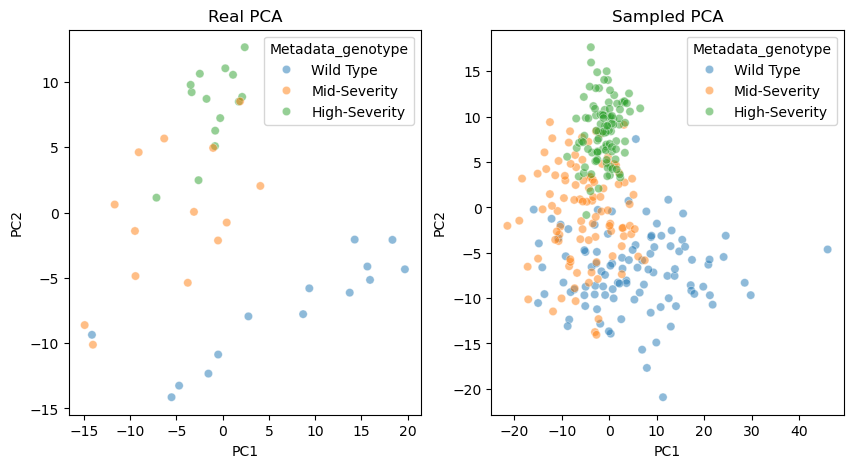

In [15]:
# Visualization of the last trial's sampled points

# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sum_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()